In [1]:
import warnings
import os
from torch.utils.data import DataLoader
import torch.nn.functional as Fin
import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint as odeint
import matplotlib
matplotlib.use('Agg')
import argparse
import sys
import time
import torch
torch.manual_seed(42)
torch.cuda.empty_cache() 
import torch.optim as optim
import random
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)
import sys
import wandb
import torch.nn.functional as F
import torch.nn as nn
import xarray as xr
from torchcubicspline import(natural_cubic_spline_coeffs, 
                             NaturalCubicSpline)

In [2]:
def my_gradient(data, dim) :
    # 10, 5, 32, 64
    # 10, 1, 5, 32, 64
    squeeze=False
    if data.dim() == 5:
        squeeze=True
        data = data.squeeze(1)
        dim = dim - 1
        
    if dim==2 :
        pad = nn.CircularPad2d((0,0,2,2))
    if dim==3 :
        pad = nn.CircularPad2d((2,2,0,0))
        
    out = pad(data)
    out = torch.gradient(out, dim=dim)[0]

    if dim==2 :
        out = out[:,:,2:-2,:]
    if dim==3 :
        out = out[:,:,:,2:-2]
    if squeeze :
        out = out.unsqueeze(1)
        
    return out, 

In [3]:
# from model_function import *
# from model_utils import *
# from utils import *

In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

def get_train_test_data_without_scales_batched_monthly(data_path,train_time_scale,val_time_scale,test_time_scale,lev,spectral):
    data = xr.open_mfdataset(data_path, combine='by_coords')
    if lev in ["v","u","r","q","tisr"]:
        data = data.sel(level=500)
    data = data.resample(time="6H").nearest(tolerance="1H") # Setting data to be 6-hour cycles
    data = data.resample(time="MS").mean()

    data_train = data.sel(time=train_time_scale).load()
    data_val = data.sel(time=val_time_scale).load()
    data_test = data.sel(time=test_time_scale).load()
    data_global = data.sel(time=slice('2006','2018')).load()

    max_val = data_global.max()[lev].values.tolist()
    min_val = data_global.min()[lev].values.tolist()

    data_train_final = (data_train - min_val)/ (max_val - min_val)
    data_val_final = (data_val - min_val)/ (max_val - min_val)
    data_test_final = (data_test - min_val)/ (max_val - min_val)

    time_vals = data_test_final.time.values
    train_times = [i for i in range(2006,2016)]
    test_times = [2017,2018]
    val_times = [2016]

    train_data = get_batched_monthly(train_times,data_train_final,lev)
    test_data = get_batched_monthly(test_times,data_test_final,lev)
    val_data = get_batched_monthly(val_times,data_val_final,lev)


    t = [i for i in range(12)]
    time_steps = torch.tensor(t).view(-1,1)

    return train_data,val_data,test_data,time_steps,data.lat.values,data.lon.values,max_val,min_val,time_vals


def get_batched_monthly(train_times,data_train_final,lev):
    for idx,year in enumerate(train_times):
        data_per_year = data_train_final.sel(time=slice(str(year),str(year))).load()
        data_values = data_per_year[lev].values
        t_data = torch.from_numpy(data_values).reshape(-1,1,1,data_values.shape[-2],data_values.shape[-1])
        if idx ==0:
            train_data = t_data
        else:
            train_data = torch.cat([train_data,t_data],dim=1)
    
    return train_data

def add_constant_info(path):
    print(path)
    data = xr.open_mfdataset(path, combine='by_coords')
    for idx,var in enumerate(['orography','lsm']):
        var_value = torch.from_numpy(data[var].values).view(1,1,32,64)
        if idx ==0: final_var = var_value
        else:
            final_var = torch.cat([final_var,var_value],dim=1)

    return final_var,torch.from_numpy(data['lat2d'].values),torch.from_numpy(data['lon2d'].values)

In [5]:
set_seed(42)
cwd = os.getcwd()
#data_path = {'z500':str(cwd) + '/era5_data/geopotential_500/*.nc','t850':str(cwd) + '/era5_data/temperature_850/*.nc'}
SOLVERS = ["dopri8","dopri5", "bdf", "rk4", "midpoint", 'adams', 'explicit_adams', 'fixed_adams',"adaptive_heun","euler"]
parser = argparse.ArgumentParser('ClimODE')
parser.add_argument('--solver', type=str, default="euler", choices=SOLVERS)
parser.add_argument('--atol', type=float, default=5e-3)
parser.add_argument('--rtol', type=float, default=5e-3)
parser.add_argument("--step_size", type=float, default=None, help="Optional fixed step size.")
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--teacher', type=int, default=1,choices=[0,1])
parser.add_argument('--scale', type=int, default=0)
parser.add_argument('--days', type=int, default=3)
parser.add_argument('--batch_size', type=int, default=3)
parser.add_argument('--spectral', type=int, default=0,choices=[0,1])
parser.add_argument('--lr', type=float, default=0.0005)
parser.add_argument('--weight_decay', type=float, default=1e-5)
parser.add_argument('--loss_type', type=int, default=0,choices=[0,1])
args = parser.parse_args(args=[])


Random seed set as 42


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


train_time_scale= slice('2006','2016')
val_time_scale = slice('2016','2016')
test_time_scale = slice('2017','2018')

In [7]:
paths_to_data = [str(cwd) + '/era5_data/geopotential_500/*.nc',str(cwd) + '/era5_data/temperature_850/*.nc',str(cwd) + '/era5_data/2m_temperature/*.nc',str(cwd) + '/era5_data/10m_u_component_of_wind/*.nc',str(cwd) + '/era5_data/10m_v_component_of_wind/*.nc']
const_info_path = ['./era5_data/constants/constants_5.625deg.nc']#/scratch/project_2006852/PDE_climate
levels = ["z","t","t2m","u10","v10","v","u","r","q"]
paths_to_data = paths_to_data[0:5]
levels = levels[0:5]
assert len(paths_to_data) == len(levels), "Paths to different type of data must be same as number of types of observations"
print("############################ Data is loading ###########################")
Final_train_data = 0
Final_val_data = 0
Final_test_data = 0
max_lev = []
min_lev = []
for idx,data in enumerate(paths_to_data):
    Train_data,Val_data,Test_data,time_steps,lat,lon,mean,std,time_stamp = get_train_test_data_without_scales_batched_monthly(data,train_time_scale,val_time_scale,test_time_scale,levels[idx],args.spectral)  
    max_lev.append(mean)
    min_lev.append(std)
    if idx==0: 
        Final_train_data = Train_data
        Final_val_data = Val_data
        Final_test_data = Test_data
    else:
        Final_train_data = torch.cat([Final_train_data,Train_data],dim=2)
        Final_val_data = torch.cat([Final_val_data,Val_data],dim=2)
        Final_test_data = torch.cat([Final_test_data,Test_data],dim=2)

print("Length of training data",len(Final_train_data))
print("Length of validation data",len(Final_val_data))
print("Length of testing data",len(Final_test_data))
const_channels_info,lat_map,lon_map = add_constant_info(const_info_path)
if args.spectral == 1: print("############## Running the Model in Spectral Domain ####################")
H,W = Train_data.shape[3],Train_data.shape[4]
Train_loader = DataLoader(Final_train_data[2:],batch_size=args.batch_size,shuffle=False,pin_memory=False)
Val_loader = DataLoader(Final_val_data[2:],batch_size=args.batch_size,shuffle=False,pin_memory=False)
Test_loader = DataLoader(Final_test_data[2:],batch_size=args.batch_size,shuffle=False,pin_memory=False)
time_loader = DataLoader(time_steps[2:],batch_size=args.batch_size,shuffle=False,pin_memory=False)
time_idx_steps = torch.tensor([i for i in range(12)]).view(-1,1)
time_idx = DataLoader(time_idx_steps[2:],batch_size=args.batch_size,shuffle=False,pin_memory=False)


############################ Data is loading ###########################


/home/namkyeong/anaconda3/envs/clim_ode/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/namkyeong/anaconda3/envs/clim_ode/lib/python3.9/site-packages/xarray/core/indexes.py:561: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)
/home/namkyeong/anaconda3/envs/clim_ode/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/namkyeong/anaconda3/envs/clim_ode/lib/python3.9/site-packages/xarray/core/indexes.py:561: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tol

Length of training data 12
Length of validation data 12
Length of testing data 12
['./era5_data/constants/constants_5.625deg.nc']


# Gradient

In [8]:
class Climate_encoder_free_uncertain_monthly(nn.Module): 
    
    def __init__(self,num_channels,const_channels,out_types,method,use_att,use_err,use_pos):
        super().__init__()
        self.layers = [4,3,2]
        self.hidden = [128,64,2*out_types]
        input_channels = 50 
        self.vel_f = Climate_ResNet_2D(input_channels,self.layers,self.hidden)

        if use_att: 
            self.vel_att = Self_attn_conv(input_channels,10)
            self.gamma = nn.Parameter(torch.tensor([0.1]))

        self.scales = num_channels
        self.const_channel = const_channels
        
        self.out_ch = out_types
        self.past_samples = 0
        self.const_info = 0
        self.lat_map = 0
        self.lon_map = 0
        self.elev = 0
        self.pos_emb = 0
        self.elev_info_grad_x = 0
        self.elev_info_grad_y = 0
        self.method = method
        err_in = 29
        if use_err: self.noise_net = Climate_ResNet_2D(err_in,[3,2,2],[128,64,2*out_types])
        if use_pos: self.pos_enc = Climate_ResNet_2D(4,[2,1,1],[32,16,out_types])
        self.att = use_att
        self.err = use_err
        self.pos = use_pos
        self.pos_feat = 0
        self.lsm =0 
        self.oro =0 


    def update_param(self, params):
        self.past_samples = params[0]
        self.const_info = params[1]
        self.lat_map = params[2]
        self.lon_map = params[3]

    def pde(self,t,vs):

        ds = vs[:,-self.out_ch:,:,:].float().view(-1,self.out_ch,vs.shape[2],vs.shape[3]).float()
        v = vs[:,:2*self.out_ch,:,:].float().view(-1,2*self.out_ch,vs.shape[2],vs.shape[3]).float()

        t_emb = ((t*100)%6).view(1,1,1,1).expand(ds.shape[0],1,ds.shape[2],ds.shape[3])
        sin_t_emb = torch.sin(torch.pi*t_emb/(12*6) - torch.pi/2)
        cos_t_emb = torch.cos(torch.pi*t_emb/(12*6)- torch.pi/2)
        

        day_emb = torch.cat([sin_t_emb,cos_t_emb],dim=1)

        ds_grad_x = my_gradient(ds,dim=3)[0]
        ds_grad_y = my_gradient(ds,dim=2)[0]
        nabla_u = torch.cat([ds_grad_x,ds_grad_y],dim=1)

        if self.pos:
            comb_rep = torch.cat([t_emb/6,day_emb,nabla_u,v,ds,self.pos_feat],dim=1)
        else:
            cos_lat_map,sin_lat_map = torch.cos(self.new_lat_map),torch.sin(self.new_lat_map)
            cos_lon_map,sin_lon_map = torch.cos(self.new_lon_map),torch.sin(self.new_lon_map)
            t_cyc_emb = day_emb
            pos_feats = torch.cat([cos_lat_map,cos_lon_map,sin_lat_map,sin_lon_map,sin_lat_map*cos_lon_map,sin_lat_map*sin_lon_map],dim=1)
            pos_time_ft = self.get_time_pos_embedding(t_cyc_emb,pos_feats)
            comb_rep = torch.cat([t_emb/6,day_emb,nabla_u,v,ds,self.new_lat_map,self.new_lon_map,self.lsm,self.oro,pos_feats,pos_time_ft],dim=1)

        if self.att: dv = self.vel_f(comb_rep) + self.gamma*self.vel_att(comb_rep)
        else: dv = self.vel_f(comb_rep)
        v_x = v[:,:self.out_ch,:,:].float().view(-1,self.out_ch,vs.shape[2],vs.shape[3]).float()
        v_y = v[:,-self.out_ch:,:,:].float().view(-1,self.out_ch,vs.shape[2],vs.shape[3]).float()

        adv1 = v_x*ds_grad_x + v_y*ds_grad_y
        adv2 = ds*(my_gradient(v_x,dim=3)[0] + my_gradient(v_y,dim=2)[0] )

        ds = adv1 + adv2

        dvs = torch.cat([dv,ds],1)
        return dvs
    
    

    def get_time_pos_embedding(self,time_feats,pos_feats):
        for idx in range(time_feats.shape[1]):
            tf = time_feats[:,idx].unsqueeze(dim=1)*pos_feats
            if idx == 0:
                final_out = tf
            else:
                final_out = torch.cat([final_out,tf],dim=1)

        return final_out

    def noise_net_contrib(self,t,pos_enc,s_final,noise_net,H,W):

        t_emb = (t%6).view(-1,1,1,1,1)
        sin_t_emb = torch.sin(torch.pi*t_emb/(12*6) - torch.pi/2).expand(len(s_final),s_final.shape[1],1,H,W)
        cos_t_emb = torch.cos(torch.pi*t_emb/(12*6) - torch.pi/2).expand(len(s_final),s_final.shape[1],1,H,W)
        

        pos_enc = pos_enc.expand(len(s_final),s_final.shape[1],-1,H,W).flatten(start_dim=0,end_dim=1)
        t_cyc_emb = torch.cat([sin_t_emb,cos_t_emb],dim=2).flatten(start_dim=0,end_dim=1)

        pos_time_ft = self.get_time_pos_embedding(t_cyc_emb,pos_enc[:,2:-2])

        comb_rep = torch.cat([t_cyc_emb,s_final.flatten(start_dim=0,end_dim=1),pos_enc,pos_time_ft],dim=1)
        final_out = noise_net(comb_rep).view(len(t),-1,2*self.out_ch,H,W)

        mean = s_final + final_out[:,:,:self.out_ch]
        std = nn.Softplus()(final_out[:,:,self.out_ch:])
        
        return mean,std


    def forward(self,T,data,atol=0.1,rtol=0.1):
        H,W = self.past_samples.shape[2],self.past_samples.shape[3]
        final_data = torch.cat([self.past_samples ,data.float().view(-1,self.out_ch,H,W)],1)
        init_time = T[0].item()*6
        final_time = T[-1].item()*6
        steps_val = final_time - init_time
        
        #breakpoint()

        if self.pos:
            lat_map = self.lat_map.unsqueeze(dim=0)*torch.pi/180
            lon_map = self.lon_map.unsqueeze(dim=0)*torch.pi/180
            pos_rep = torch.cat([lat_map.unsqueeze(dim=0),lon_map.unsqueeze(dim=0),self.const_info],dim=1)
            self.pos_feat = self.pos_enc(pos_rep).expand(data.shape[0],-1,data.shape[3],data.shape[4])
            final_pos_enc = self.pos_feat
        
        else:
            self.oro,self.lsm = self.const_info[0,0],self.const_info[0,1]
            self.lsm = self.lsm.unsqueeze(dim=0).expand(data.shape[0],-1,data.shape[3],data.shape[4])
            self.oro  = F.normalize(self.const_info[0,0]).unsqueeze(dim=0).expand(data.shape[0],-1,data.shape[3],data.shape[4])
            self.new_lat_map = self.lat_map.expand(data.shape[0],1,data.shape[3],data.shape[4])*torch.pi/180 # Converting to radians
            self.new_lon_map = self.lon_map.expand(data.shape[0],1,data.shape[3],data.shape[4])*torch.pi/180
            cos_lat_map,sin_lat_map = torch.cos(self.new_lat_map),torch.sin(self.new_lat_map)
            cos_lon_map,sin_lon_map = torch.cos(self.new_lon_map),torch.sin(self.new_lon_map)
            pos_feats = torch.cat([cos_lat_map,cos_lon_map,sin_lat_map,sin_lon_map,sin_lat_map*cos_lon_map,sin_lat_map*sin_lon_map],dim=1)
            final_pos_enc = torch.cat([self.new_lat_map,self.new_lon_map,pos_feats,self.lsm,self.oro],dim=1)


        new_time_steps = torch.linspace(init_time,final_time,steps=int(steps_val)+1).to(data.device)
        t = 0.01*new_time_steps.float().to(data.device).flatten().float()
        pde_rhs  = lambda t,vs: self.pde(t,vs) # make the ODE forward function
        final_result = odeint(pde_rhs,final_data,t,method=self.method,atol=atol,rtol=rtol)
        s_final = final_result[:,:,-self.out_ch:,:,:].view(len(t),-1,self.out_ch,H,W)

        if self.err:
            mean,std = self.noise_net_contrib(T,final_pos_enc,s_final[0:len(s_final):6],self.noise_net,H,W)

        else:
            s_final = s_final[0:len(s_final):6]

        return mean,std,s_final[0:len(s_final):6]

In [9]:
class Climate_ResNet_2D(nn.Module): 
    
    def __init__(self,num_channels,layers,hidden_size):
        super().__init__()
        layers_cnn = []
        activation_fns = []
        self.block = ResidualBlock
        self.inplanes = num_channels

        for idx in range(len(layers)):
            if idx ==0:
                layers_cnn.append(self.make_layer(self.block,num_channels,hidden_size[idx],layers[idx]))
            else:
                layers_cnn.append(self.make_layer(self.block,hidden_size[idx-1],hidden_size[idx],layers[idx]))
        
        self.layer_cnn = nn.ModuleList(layers_cnn)
        self.activation_cnn = nn.ModuleList(activation_fns)

    def make_layer(self,block,in_channels,out_channels,reps):
        layers = []
        layers.append(block(in_channels,out_channels))
        self.inplanes = out_channels
        for i in range(1, reps):  
              layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self,data):
        dx_final = data.float()
        for l,layer in enumerate(self.layer_cnn):
            dx_final = layer(dx_final)

                
        return dx_final
    
class ResidualBlock(nn.Module):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        activation: str = "gelu",
        norm: bool = False,
        n_groups: int = 1,
    ):
        super().__init__()
        self.activation = nn.LeakyReLU(0.3)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=0)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.drop = nn.Dropout(p=0.1)
        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        if norm:
            self.norm1 = nn.GroupNorm(n_groups, in_channels)
            self.norm2 = nn.GroupNorm(n_groups, out_channels)
        else:
            self.norm1 = nn.Identity()
            self.norm2 = nn.Identity()

    def forward(self, x: torch.Tensor):
        # First convolution layer
        x_mod = F.pad(F.pad(x,(0,0,1,1),'reflect'),(1,1,0,0),'circular')
        h = self.activation(self.bn1(self.conv1(self.norm1(x_mod))))
        # Second convolution layer
        h = F.pad(F.pad(h,(0,0,1,1),'reflect'),(1,1,0,0),'circular')
        h = self.activation(self.bn2(self.conv2(self.norm2(h))))
        h = self.drop(h)
        # Add the shortcut connection and return
        return h + self.shortcut(x)


class Self_attn_conv(nn.Module):
    
    def __init__(self, in_channels,out_channels):
        super(Self_attn_conv, self).__init__()
        self.query = self._conv(in_channels,in_channels//8,stride=1)
        self.key = self.key_conv(in_channels,in_channels//8,stride=2)
        self.value = self.key_conv(in_channels,out_channels,stride=2)
        self.post_map = nn.Sequential(nn.Conv2d(out_channels,out_channels,kernel_size=(1,1),stride=1,padding=0))
        self.out_ch = out_channels

    def _conv(self,n_in,n_out,stride):
        return nn.Sequential(boundarypad(),nn.Conv2d(n_in,n_in//2,kernel_size=(3,3),stride=stride,padding=0),nn.LeakyReLU(0.3),boundarypad(),nn.Conv2d(n_in//2,n_out,kernel_size=(3,3),stride=stride,padding=0),nn.LeakyReLU(0.3),boundarypad(),nn.Conv2d(n_out,n_out,kernel_size=(3,3),stride=stride,padding=0))
    
    def key_conv(self,n_in,n_out,stride):
        return nn.Sequential(nn.Conv2d(n_in,n_in//2,kernel_size=(3,3),stride=stride,padding=0),nn.LeakyReLU(0.3),nn.Conv2d(n_in//2,n_out,kernel_size=(3,3),stride=stride,padding=0),nn.LeakyReLU(0.3),nn.Conv2d(n_out,n_out,kernel_size=(3,3),stride=1,padding=0))
    
    def forward(self, x):
        size = x.size()
        x = x.float()
        q,k,v = self.query(x).flatten(-2,-1),self.key(x).flatten(-2,-1),self.value(x).flatten(-2,-1)
        beta = F.softmax(torch.bmm(q.transpose(1,2), k), dim=1)
        o = torch.bmm(v, beta.transpose(1,2))
        o = self.post_map(o.view(-1,self.out_ch,size[-2],size[-1]).contiguous())
        return o

class boundarypad(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return F.pad(F.pad(input,(0,0,1,1),'reflect'),(1,1,0,0),'circular')


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_gauss_kernel(shape,lat,lon):
    cwd = os.getcwd()
    rows,columns  = shape
    kernel = torch.zeros(shape[0]*shape[1],shape[0]*shape[1])
    pos = []
    for i in range(rows):
        for j in range(columns):
            pos.append([lat[i],lon[j]])

    for i in range(rows*columns):
        for j in range(rows*columns):
            dist = torch.sum((torch.tensor(pos[i]) - torch.tensor(pos[j]))**2)
            kernel[i][j] = torch.exp(-dist/(2*1*1))

    kernel_inv = torch.linalg.inv(kernel).numpy()
    np.save(str(cwd) +"/kernel.npy",kernel_inv)

In [10]:
num_years = len(range(2006,2016))
model = Climate_encoder_free_uncertain_monthly(len(paths_to_data),2,out_types=len(paths_to_data),method=args.solver,use_att=True,use_err=True,use_pos=False).to(device)
param = count_parameters(model)
optimizer = optim.AdamW(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.niters)

best_loss = float('inf')
train_best_loss = float('inf')
best_epoch = float('inf')
print("############################ Data is loaded, Fitting the velocity #########################")

#get_gauss_kernel((32,64),lat,lon)
kernel = torch.from_numpy(np.load(str(cwd) +"/kernel.npy"))

############################ Data is loaded, Fitting the velocity #########################


/home/namkyeong/anaconda3/envs/clim_ode/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Gradient

In [11]:
class Optim_velocity(nn.Module):
    def __init__(self,num_years,H,W):
        super(Optim_velocity,self).__init__()
        self.v_x = torch.nn.Parameter(torch.randn(num_years,1,5,H,W))
        self.v_y = torch.nn.Parameter(torch.randn(num_years,1,5,H,W))

    def forward(self,data):
        #print('data size: ', data.size())
        u_y = my_gradient(data,dim=3)[0] # (H,W) --> (y,x)
        u_x = my_gradient(data,dim=4)[0]
        #print('self.v_y size: ', self.v_y.size())
        adv = self.v_x*u_x + self.v_y*u_y + data*(my_gradient(self.v_y,dim=3)[0] + my_gradient(self.v_x,dim=4)[0])
        out = adv
        return out,self.v_x,self.v_y 

In [12]:
def nll(mean,std,truth,lat,var_coeff):
    normal_lkl = torch.distributions.normal.Normal(mean, 1e-3 + std)
    lkl = - normal_lkl.log_prob(truth)
    loss_val = lkl.mean() + var_coeff*(std**2).sum()
    #loss_val = torch.mean(lkl,dim=(0,1,3,4))
    return loss_val

def get_delta_u(u_vel,t_steps):
    levels = ["z","t","t2m","u10","v10","tisr","v","u","r","q"]
    t = t_steps.flatten().float()*6
    title = {"z":"Geopotential","v10": "v component of wind at 10m","u10": "u component of wind at 10m","t2m": "Temperature at 2m","t": "Temperature at 850hPa pressure"}
    input_u_vel = u_vel.view(u_vel.shape[0],u_vel.shape[1],-1)
    coeffs = natural_cubic_spline_coeffs(t, input_u_vel)
    spline = NaturalCubicSpline(coeffs)
    point = t[-1]
    out = spline.derivative(point).view(-1,u_vel.shape[2],u_vel.shape[3],u_vel.shape[4])
    
    return out


def optimize_vel(num,data,delta_u,vel_model,kernel,H,W,steps=200):
    model = vel_model(num,H,W)
    optimizer = optim.Adam(model.parameters(),lr=2)
    best_loss = float('inf')
    loss_step = []
    out,v_x,v_y = model(data)
    for step in range(steps):
        optimizer.zero_grad()
        out,v_x,v_y = model(data)
        kernel_v_x = v_x.view(num,5,-1,1)
        kernel_v_y = v_y.view(num,5,-1,1)
        kernel_expand = kernel.expand(num,5,kernel.shape[0],kernel.shape[1])
        v_x_kernel  = torch.matmul(kernel_v_x.transpose(2,3), kernel_expand)
        final_x = torch.matmul(v_x_kernel, kernel_v_x).mean()
        v_y_kernel  = torch.matmul(kernel_v_y.transpose(2,3), kernel_expand)
        final_y = torch.matmul(v_y_kernel, kernel_v_y).mean() 
        vel_loss = nn.MSELoss()(delta_u,out.squeeze(dim=1)) + 0.0000001*(final_x + final_y)
        loss_step.append(vel_loss.item())
        if vel_loss.item() < best_loss:
            best_loss = vel_loss.item()
            final_vx = v_x
            final_vy = v_y
            final_out = out
        vel_loss.backward()
        optimizer.step()
    print(best_loss)
    return final_vx,final_vy,loss_step,final_out



def fit_velocity(time_idx,time_loader,Final_train_data,data_loader,device,num_years,paths_to_data,scale,H,W,types,vel_model,kernel,lat,lon):
    num =0
    cwd = os.getcwd() 
    for idx_steps,time_steps,batch in zip(time_idx,time_loader,data_loader):
        pst = [time_steps[0].item()-i for i in range(3)]
        pst.reverse()
        pst_idx = [idx_steps[0].item()-i for i in range(3)]
        pst_idx.reverse()
        past_time = torch.tensor(pst).to(device)
        data = batch[0].to(device).view(num_years,1,len(paths_to_data)*(scale+1),H,W)
        past_sample = [Final_train_data[j].view(num_years,-1,len(paths_to_data)*(scale+1),H,W) for j in pst_idx]
        past_sample = torch.stack(past_sample).view(num_years,3,-1,H,W).to(device)
        delta_u = get_delta_u(past_sample,past_time)
        v_x,v_y,loss_terms,out = optimize_vel(num_years,data,delta_u,vel_model,kernel,H,W)
        final_v = torch.cat([v_x,v_y],dim=1).unsqueeze(dim=0)
        if num == 0:
            Final_v = final_v
        else:
            Final_v = torch.cat([Final_v,final_v],dim=0)
        num = num+1

    if os.path.exists(str(cwd) +"/" + types + "_vel_gradient_modified_pad2.npy"):
        os.remove(str(cwd) +"/" + types + "_vel_gradient_modified_pad2.npy")

    np.save(str(cwd) +"/" + types + "_vel_gradient_modified_pad2.npy",Final_v.detach().numpy())
    
def load_velocity(types):
    cwd = os.getcwd()
    vel = []
    for file in types:
        vel.append(np.load(str(cwd) + "/" + file + "_vel_gradient_modified_pad2.npy"))

    return (torch.from_numpy(v) for v in vel)

In [13]:
fit_velocity(time_idx,time_loader,Final_train_data,Train_loader,torch.device('cpu'),num_years,paths_to_data,args.scale,H,W,types='train_monthly',vel_model=Optim_velocity,kernel=kernel,lat=lat,lon=lon)
fit_velocity(time_idx,time_loader,Final_val_data,Val_loader,torch.device('cpu'),1,paths_to_data,args.scale,H,W,types='val_monthly',vel_model=Optim_velocity,kernel=kernel,lat=lat,lon=lon)
fit_velocity(time_idx,time_loader,Final_test_data,Test_loader,torch.device('cpu'),2,paths_to_data,args.scale,H,W,types='test_monthly',vel_model=Optim_velocity,kernel=kernel,lat=lat,lon=lon)

vel_train,vel_val = load_velocity(['train_monthly','val_monthly'])
print("############################ Velocity loaded, Model starts to train #########################")
print(model)
print("####################### Total Parameters",param ,"################################")
model.train()

0.00010879666660912335
0.0001236649986822158
0.00012661542859859765
0.0001080036599887535
0.00011096575326519087
0.00012157019227743149
0.00013229127216618508
0.00011100822302978486
0.00011746177915483713
0.00012462225276976824
0.00012113949924241751
0.00011078453826485202
############################ Velocity loaded, Model starts to train #########################
Climate_encoder_free_uncertain_monthly(
  (vel_f): Climate_ResNet_2D(
    (layer_cnn): ModuleList(
      (0): Sequential(
        (0): ResidualBlock(
          (activation): LeakyReLU(negative_slope=0.3)
          (conv1): Conv2d(50, 128, kernel_size=(3, 3), stride=(1, 1))
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop): Dropout(p=0.1, inplace=False)
          (shortcut): Conv2d(50, 128, kerne

Climate_encoder_free_uncertain_monthly(
  (vel_f): Climate_ResNet_2D(
    (layer_cnn): ModuleList(
      (0): Sequential(
        (0): ResidualBlock(
          (activation): LeakyReLU(negative_slope=0.3)
          (conv1): Conv2d(50, 128, kernel_size=(3, 3), stride=(1, 1))
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop): Dropout(p=0.1, inplace=False)
          (shortcut): Conv2d(50, 128, kernel_size=(1, 1), stride=(1, 1))
          (norm1): Identity()
          (norm2): Identity()
        )
        (1): ResidualBlock(
          (activation): LeakyReLU(negative_slope=0.3)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2)

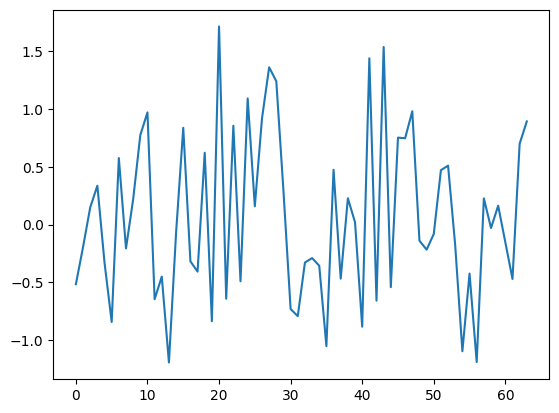

In [14]:
%matplotlib inline
plt.plot(vel_train[0,0,0,0,8,:])
plt.show()

In [15]:
for epoch in range(args.niters):
    total_train_loss = 0
    val_loss = 0
    test_loss = 0
    if epoch == 0:
        var_coeff = 0.001
    else:
        var_coeff = 2*scheduler.get_last_lr()[0]
    
    for entry,(time_steps,batch) in enumerate(zip(time_loader,Train_loader)):
        optimizer.zero_grad()
        data = batch[0].to(device).view(num_years,1,len(paths_to_data)*(args.scale+1),H,W)
        past_sample = vel_train[entry].view(num_years,2*len(paths_to_data)*(args.scale+1),H,W).to(device)
        model.update_param([past_sample,const_channels_info.to(device),lat_map.to(device),lon_map.to(device)])
        t = time_steps.float().to(device).flatten()
       
        mean,std,_ = model(t,data)
            
        loss = nll(mean,std,batch.float().to(device),lat,var_coeff)
            
        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum()
                for p in model.parameters())
        loss = loss + l2_lambda * l2_norm
        loss.backward()
        optimizer.step()    
        print("Loss for batch is ",loss.item())
        if torch.isnan(loss) : 
            print("Quitting due to Nan loss")
            quit()
        total_train_loss = total_train_loss + loss.item()

    lr_val = scheduler.get_last_lr()[0]
    scheduler.step()
   
    print("|Iter ",epoch," | Total Train Loss ", total_train_loss,"|")
        

    for entry,(time_steps,batch) in enumerate(zip(time_loader,Val_loader)):
        data = batch[0].to(device).view(1,1,len(paths_to_data)*(args.scale+1),H,W)
        past_sample = vel_val[entry].view(1,2*len(paths_to_data)*(args.scale+1),H,W).to(device)
        model.update_param([past_sample,const_channels_info.to(device),lat_map.to(device),lon_map.to(device)])
        t = time_steps.float().to(device).flatten()
         
        mean,std,_ = model(t,data)
               
        loss = nll(mean,std,batch.float().to(device),lat,var_coeff)
        if torch.isnan(loss) : 
            print("Quitting due to Nan loss")
            quit()
      
        print("Val Loss for batch is ",loss.item())
        val_loss = val_loss + loss.item()

    print("|Iter ",epoch," | Total Val Loss ", val_loss,"|")



    if val_loss < best_loss:
        best_loss = val_loss
        best_epoch = epoch
        torch.save(model,str(cwd) + "/Models/gradient_modified/" + "ClimODE_monthly_avg_"+args.solver+"_"+str(args.spectral)+"_model_pad2.pt")

    if total_train_loss < train_best_loss:
        train_best_loss = total_train_loss
        torch.save(model,str(cwd) + "/Models/gradient_modified/" + "ClimODE_monthly_avg_overfit_"+args.solver+"_"+str(args.spectral)+"_model_pad2_" + str(epoch) + ".pt")


Loss for batch is  702.4989013671875
Loss for batch is  747.1881713867188
Loss for batch is  599.2195434570312
Loss for batch is  140.92962646484375
|Iter  0  | Total Train Loss  2189.8362426757812 |
Val Loss for batch is  39.056488037109375
Val Loss for batch is  38.678863525390625
Val Loss for batch is  39.2478141784668
Val Loss for batch is  15.922685623168945
|Iter  0  | Total Val Loss  132.90585136413574 |
Loss for batch is  351.5543518066406
Loss for batch is  296.7303466796875
Loss for batch is  252.26998901367188
Loss for batch is  78.32789611816406
|Iter  1  | Total Train Loss  978.8825836181641 |
Val Loss for batch is  23.983177185058594
Val Loss for batch is  23.85585594177246
Val Loss for batch is  24.08226203918457
Val Loss for batch is  11.620111465454102
|Iter  1  | Total Val Loss  83.54140663146973 |
Loss for batch is  195.46849060058594
Loss for batch is  173.11239624023438
Loss for batch is  152.2373809814453
Loss for batch is  52.128055572509766
|Iter  2  | Total Tra

Loss for batch is  17.705585479736328
Loss for batch is  17.596820831298828
Loss for batch is  17.524003982543945
Loss for batch is  11.304322242736816
|Iter  20  | Total Train Loss  64.13073253631592 |
Val Loss for batch is  6.18039083480835
Val Loss for batch is  6.414510726928711
Val Loss for batch is  6.496344089508057
Val Loss for batch is  5.7970123291015625
|Iter  20  | Total Val Loss  24.88825798034668 |
Loss for batch is  17.196680068969727
Loss for batch is  17.044090270996094
Loss for batch is  17.101207733154297
Loss for batch is  11.076870918273926
|Iter  21  | Total Train Loss  62.41884899139404 |
Val Loss for batch is  6.028713226318359
Val Loss for batch is  6.020188808441162
Val Loss for batch is  5.998263835906982
Val Loss for batch is  5.4288482666015625
|Iter  21  | Total Val Loss  23.476014137268066 |
Loss for batch is  16.859704971313477
Loss for batch is  16.757240295410156
Loss for batch is  16.724166870117188
Loss for batch is  10.941854476928711
|Iter  22  | T

Loss for batch is  13.315813064575195
Loss for batch is  13.074831008911133
Loss for batch is  13.194337844848633
Loss for batch is  8.758953094482422
|Iter  40  | Total Train Loss  48.34393501281738 |
Val Loss for batch is  4.462689399719238
Val Loss for batch is  4.432924270629883
Val Loss for batch is  4.616924285888672
Val Loss for batch is  4.38262939453125
|Iter  40  | Total Val Loss  17.895167350769043 |
Loss for batch is  13.14543342590332
Loss for batch is  12.983929634094238
Loss for batch is  13.043366432189941
Loss for batch is  8.639445304870605
|Iter  41  | Total Train Loss  47.812174797058105 |
Val Loss for batch is  4.475697040557861
Val Loss for batch is  4.393117427825928
Val Loss for batch is  4.315075874328613
Val Loss for batch is  3.936729907989502
|Iter  41  | Total Val Loss  17.120620250701904 |
Loss for batch is  12.919729232788086
Loss for batch is  12.828116416931152
Loss for batch is  12.811442375183105
Loss for batch is  8.588340759277344
|Iter  42  | Total

Loss for batch is  10.934136390686035
Loss for batch is  10.840278625488281
Loss for batch is  10.887079238891602
Loss for batch is  7.390399932861328
|Iter  60  | Total Train Loss  40.051894187927246 |
Val Loss for batch is  3.5042574405670166
Val Loss for batch is  3.5870370864868164
Val Loss for batch is  3.6513023376464844
Val Loss for batch is  2.963245153427124
|Iter  60  | Total Val Loss  13.705842018127441 |
Loss for batch is  10.87303352355957
Loss for batch is  10.756378173828125
Loss for batch is  10.832026481628418
Loss for batch is  7.2176513671875
|Iter  61  | Total Train Loss  39.67908954620361 |
Val Loss for batch is  3.5756280422210693
Val Loss for batch is  3.5597400665283203
Val Loss for batch is  3.5778136253356934
Val Loss for batch is  2.89555287361145
|Iter  61  | Total Val Loss  13.608734607696533 |
Loss for batch is  10.767465591430664
Loss for batch is  10.607254028320312
Loss for batch is  10.726641654968262
Loss for batch is  7.187183380126953
|Iter  62  | T

Loss for batch is  9.227691650390625
Loss for batch is  9.149624824523926
Loss for batch is  9.196882247924805
Loss for batch is  6.135437965393066
|Iter  80  | Total Train Loss  33.70963668823242 |
Val Loss for batch is  2.776137351989746
Val Loss for batch is  2.78269362449646
Val Loss for batch is  2.802603006362915
Val Loss for batch is  2.1493778228759766
|Iter  80  | Total Val Loss  10.510811805725098 |
Loss for batch is  9.141353607177734
Loss for batch is  9.030829429626465
Loss for batch is  9.161503791809082
Loss for batch is  6.200193405151367
|Iter  81  | Total Train Loss  33.53388023376465 |
Val Loss for batch is  2.741969585418701
Val Loss for batch is  2.451768636703491
Val Loss for batch is  2.865966796875
Val Loss for batch is  2.026749610900879
|Iter  81  | Total Val Loss  10.086454629898071 |
Loss for batch is  9.119762420654297
Loss for batch is  8.972496032714844
Loss for batch is  9.117570877075195
Loss for batch is  6.085235595703125
|Iter  82  | Total Train Loss

Loss for batch is  7.800950050354004
Loss for batch is  7.709844589233398
Loss for batch is  7.852319717407227
Loss for batch is  5.1302995681762695
|Iter  100  | Total Train Loss  28.4934139251709 |
Val Loss for batch is  1.9288867712020874
Val Loss for batch is  1.952347755432129
Val Loss for batch is  2.276841163635254
Val Loss for batch is  1.5660676956176758
|Iter  100  | Total Val Loss  7.724143385887146 |
Loss for batch is  7.78079891204834
Loss for batch is  7.592223644256592
Loss for batch is  7.818648815155029
Loss for batch is  5.073623180389404
|Iter  101  | Total Train Loss  28.265294551849365 |
Val Loss for batch is  2.0524911880493164
Val Loss for batch is  1.8711209297180176
Val Loss for batch is  2.0563340187072754
Val Loss for batch is  1.6086194515228271
|Iter  101  | Total Val Loss  7.5885655879974365 |
Loss for batch is  7.736187934875488
Loss for batch is  7.5218424797058105
Loss for batch is  7.722125053405762
Loss for batch is  4.999155521392822
|Iter  102  | To

Loss for batch is  6.659824371337891
Loss for batch is  6.505184650421143
Loss for batch is  6.740224838256836
Loss for batch is  4.308574199676514
|Iter  120  | Total Train Loss  24.213808059692383 |
Val Loss for batch is  1.4194225072860718
Val Loss for batch is  1.4993973970413208
Val Loss for batch is  1.6671326160430908
Val Loss for batch is  0.7822785377502441
|Iter  120  | Total Val Loss  5.3682310581207275 |
Loss for batch is  6.676740646362305
Loss for batch is  6.5212602615356445
Loss for batch is  6.687427520751953
Loss for batch is  4.296574592590332
|Iter  121  | Total Train Loss  24.182003021240234 |
Val Loss for batch is  1.4472837448120117
Val Loss for batch is  1.3686895370483398
Val Loss for batch is  1.5620602369308472
Val Loss for batch is  1.0037819147109985
|Iter  121  | Total Val Loss  5.381815433502197 |
Loss for batch is  6.625997543334961
Loss for batch is  6.435692310333252
Loss for batch is  6.643115043640137
Loss for batch is  4.3441362380981445
|Iter  122 

Loss for batch is  5.801176071166992
Loss for batch is  5.584389686584473
Loss for batch is  5.866555690765381
Loss for batch is  3.612152099609375
|Iter  140  | Total Train Loss  20.86427354812622 |
Val Loss for batch is  1.3204067945480347
Val Loss for batch is  0.9322136640548706
Val Loss for batch is  1.2704015970230103
Val Loss for batch is  0.6859095692634583
|Iter  140  | Total Val Loss  4.208931624889374 |
Loss for batch is  5.760184288024902
Loss for batch is  5.533174991607666
Loss for batch is  5.830362319946289
Loss for batch is  3.7247872352600098
|Iter  141  | Total Train Loss  20.848508834838867 |
Val Loss for batch is  1.3420485258102417
Val Loss for batch is  0.9012719392776489
Val Loss for batch is  1.1302757263183594
Val Loss for batch is  0.5700554847717285
|Iter  141  | Total Val Loss  3.9436516761779785 |
Loss for batch is  5.749566078186035
Loss for batch is  5.539388656616211
Loss for batch is  5.755152702331543
Loss for batch is  3.58302640914917
|Iter  142  | 

Loss for batch is  5.063943386077881
Loss for batch is  4.822944164276123
Loss for batch is  5.161386966705322
Loss for batch is  3.172696590423584
|Iter  160  | Total Train Loss  18.22097110748291 |
Val Loss for batch is  0.8204108476638794
Val Loss for batch is  0.749550461769104
Val Loss for batch is  0.7758907675743103
Val Loss for batch is  0.13038203120231628
|Iter  160  | Total Val Loss  2.47623410820961 |
Loss for batch is  5.057182312011719
Loss for batch is  4.827999114990234
Loss for batch is  5.064977645874023
Loss for batch is  3.0735068321228027
|Iter  161  | Total Train Loss  18.02366590499878 |
Val Loss for batch is  0.853176474571228
Val Loss for batch is  0.8647613525390625
Val Loss for batch is  1.0853700637817383
Val Loss for batch is  0.23463746905326843
|Iter  161  | Total Val Loss  3.0379453599452972 |
Loss for batch is  4.9672112464904785
Loss for batch is  4.784194469451904
Loss for batch is  5.095773696899414
Loss for batch is  3.066650390625
|Iter  162  | Tot

Loss for batch is  4.49539852142334
Loss for batch is  4.3106794357299805
Loss for batch is  4.510981559753418
Loss for batch is  2.6215500831604004
|Iter  180  | Total Train Loss  15.938609600067139 |
Val Loss for batch is  0.4439508020877838
Val Loss for batch is  0.43294283747673035
Val Loss for batch is  0.6266899108886719
Val Loss for batch is  -0.2769893407821655
|Iter  180  | Total Val Loss  1.2265942096710205 |
Loss for batch is  4.490847587585449
Loss for batch is  4.2532453536987305
Loss for batch is  4.529280662536621
Loss for batch is  2.598018169403076
|Iter  181  | Total Train Loss  15.871391773223877 |
Val Loss for batch is  0.49223190546035767
Val Loss for batch is  0.27274906635284424
Val Loss for batch is  0.6774308681488037
Val Loss for batch is  -0.18995070457458496
|Iter  181  | Total Val Loss  1.2524611353874207 |
Loss for batch is  4.376522064208984
Loss for batch is  4.181889533996582
Loss for batch is  4.523647308349609
Loss for batch is  2.5939290523529053
|It

Loss for batch is  3.9509499073028564
Loss for batch is  3.759659767150879
Loss for batch is  4.0525360107421875
Loss for batch is  2.251450777053833
|Iter  200  | Total Train Loss  14.014596462249756 |
Val Loss for batch is  0.28355973958969116
Val Loss for batch is  0.047105491161346436
Val Loss for batch is  0.26357579231262207
Val Loss for batch is  -0.4279201030731201
|Iter  200  | Total Val Loss  0.16632091999053955 |
Loss for batch is  3.976781129837036
Loss for batch is  3.7482872009277344
Loss for batch is  4.030467987060547
Loss for batch is  2.2550528049468994
|Iter  201  | Total Train Loss  14.010589122772217 |
Val Loss for batch is  0.2676018476486206
Val Loss for batch is  0.053431540727615356
Val Loss for batch is  0.5373984575271606
Val Loss for batch is  -0.30655884742736816
|Iter  201  | Total Val Loss  0.5518729984760284 |
Loss for batch is  3.865668296813965
Loss for batch is  3.69496488571167
Loss for batch is  4.023112773895264
Loss for batch is  2.270475625991821

Loss for batch is  3.6307148933410645
Loss for batch is  3.344773530960083
Loss for batch is  3.621187925338745
Loss for batch is  1.9728422164916992
|Iter  220  | Total Train Loss  12.569518566131592 |
Val Loss for batch is  0.037253908812999725
Val Loss for batch is  -0.08152583241462708
Val Loss for batch is  0.24845072627067566
Val Loss for batch is  -0.4517303705215454
|Iter  220  | Total Val Loss  -0.2475515678524971 |
Loss for batch is  3.581770181655884
Loss for batch is  3.315199613571167
Loss for batch is  3.651644229888916
Loss for batch is  1.942225456237793
|Iter  221  | Total Train Loss  12.49083948135376 |
Val Loss for batch is  0.03736752271652222
Val Loss for batch is  -0.10466079413890839
Val Loss for batch is  0.17053180932998657
Val Loss for batch is  -0.7311304211616516
|Iter  221  | Total Val Loss  -0.6278918832540512 |
Loss for batch is  3.538090705871582
Loss for batch is  3.311570644378662
Loss for batch is  3.5886337757110596
Loss for batch is  1.9341948032379

Loss for batch is  3.330965518951416
Loss for batch is  1.7024602890014648
|Iter  239  | Total Train Loss  11.295608520507812 |
Val Loss for batch is  -0.032931044697761536
Val Loss for batch is  -0.2018698900938034
Val Loss for batch is  0.08442463725805283
Val Loss for batch is  -0.7650729417800903
|Iter  239  | Total Val Loss  -0.9154492393136024 |
Loss for batch is  3.285086154937744
Loss for batch is  3.015172004699707
Loss for batch is  3.4302124977111816
Loss for batch is  1.671515941619873
|Iter  240  | Total Train Loss  11.401986598968506 |
Val Loss for batch is  -0.06314510107040405
Val Loss for batch is  -0.2403944581747055
Val Loss for batch is  0.09149734675884247
Val Loss for batch is  -0.7405505180358887
|Iter  240  | Total Val Loss  -0.9525927305221558 |
Loss for batch is  3.2889132499694824
Loss for batch is  3.0132687091827393
Loss for batch is  3.3599348068237305
Loss for batch is  1.647803544998169
|Iter  241  | Total Train Loss  11.309920310974121 |
Val Loss for ba

Loss for batch is  2.934413194656372
Loss for batch is  2.7236239910125732
Loss for batch is  3.047713279724121
Loss for batch is  1.4359647035598755
|Iter  259  | Total Train Loss  10.141715168952942 |
Val Loss for batch is  -0.27173173427581787
Val Loss for batch is  -0.33118385076522827
Val Loss for batch is  -0.08405019342899323
Val Loss for batch is  -0.949266254901886
|Iter  259  | Total Val Loss  -1.6362320333719254 |
Loss for batch is  2.9365718364715576
Loss for batch is  2.7284374237060547
Loss for batch is  3.029694080352783
Loss for batch is  1.3751187324523926
|Iter  260  | Total Train Loss  10.069822072982788 |
Val Loss for batch is  -0.27697694301605225
Val Loss for batch is  -0.43327295780181885
Val Loss for batch is  -0.19781433045864105
Val Loss for batch is  -0.9948769807815552
|Iter  260  | Total Val Loss  -1.9029412120580673 |
Loss for batch is  2.922102928161621
Loss for batch is  2.720583915710449
Loss for batch is  3.040755271911621
Loss for batch is  1.42353391

Loss for batch is  2.872565269470215
Loss for batch is  1.2300257682800293
|Iter  278  | Total Train Loss  9.376815795898438 |
Val Loss for batch is  -0.2660784125328064
Val Loss for batch is  -0.4190947413444519
Val Loss for batch is  -0.12288857996463776
Val Loss for batch is  -1.0022342205047607
|Iter  278  | Total Val Loss  -1.8102959543466568 |
Loss for batch is  2.743529796600342
Loss for batch is  2.536435604095459
Loss for batch is  2.851609230041504
Loss for batch is  1.3103971481323242
|Iter  279  | Total Train Loss  9.441971778869629 |
Val Loss for batch is  -0.34405380487442017
Val Loss for batch is  -0.5621267557144165
Val Loss for batch is  -0.22827847301959991
Val Loss for batch is  -1.1786547899246216
|Iter  279  | Total Val Loss  -2.313113823533058 |
Loss for batch is  2.7287516593933105
Loss for batch is  2.472703456878662
Loss for batch is  2.828641891479492
Loss for batch is  1.2482876777648926
|Iter  280  | Total Train Loss  9.278384685516357 |
Val Loss for batch i

Loss for batch is  2.4759888648986816
Loss for batch is  2.291393756866455
Loss for batch is  2.5877315998077393
Loss for batch is  1.0489685535430908
|Iter  298  | Total Train Loss  8.404082775115967 |
Val Loss for batch is  -0.4119085669517517
Val Loss for batch is  -0.5942001938819885
Val Loss for batch is  -0.33596542477607727
Val Loss for batch is  -1.2901986837387085
|Iter  298  | Total Val Loss  -2.632272869348526 |
Loss for batch is  2.535376787185669
Loss for batch is  2.257493019104004
Loss for batch is  2.5427563190460205
Loss for batch is  1.0985859632492065
|Iter  299  | Total Train Loss  8.4342120885849 |
Val Loss for batch is  -0.4466122090816498
Val Loss for batch is  -0.6336898803710938
Val Loss for batch is  -0.2304363250732422
Val Loss for batch is  -1.2191557884216309
|Iter  299  | Total Val Loss  -2.5298942029476166 |
Loss for batch is  2.4753189086914062
Loss for batch is  2.256542444229126
Loss for batch is  2.5248098373413086
Loss for batch is  1.063732504844665

Val Loss for batch is  -0.4282102882862091
Val Loss for batch is  -1.4277251958847046
|Iter  317  | Total Val Loss  -3.2414248287677765 |
Loss for batch is  2.382031202316284
Loss for batch is  2.1457290649414062
Loss for batch is  2.4600138664245605
Loss for batch is  0.9220788478851318
|Iter  318  | Total Train Loss  7.909852981567383 |
Val Loss for batch is  -0.33445364236831665
Val Loss for batch is  -0.6501140594482422
Val Loss for batch is  -0.27177566289901733
Val Loss for batch is  -1.1926097869873047
|Iter  318  | Total Val Loss  -2.448953151702881 |
Loss for batch is  2.392193555831909
Loss for batch is  2.1170177459716797
Loss for batch is  2.508626937866211
Loss for batch is  0.863329291343689
|Iter  319  | Total Train Loss  7.881167531013489 |
Val Loss for batch is  -0.5210549831390381
Val Loss for batch is  -0.7211577892303467
Val Loss for batch is  -0.41531941294670105
Val Loss for batch is  -1.3403338193893433
|Iter  319  | Total Val Loss  -2.997866004705429 |
Loss for 

Loss for batch is  2.141730308532715
Loss for batch is  1.9482393264770508
Loss for batch is  2.2395124435424805
Loss for batch is  0.7484961748123169
|Iter  337  | Total Train Loss  7.077978253364563 |
Val Loss for batch is  -0.6051225662231445
Val Loss for batch is  -0.5945282578468323
Val Loss for batch is  -0.44116854667663574
Val Loss for batch is  -1.4604535102844238
|Iter  337  | Total Val Loss  -3.1012728810310364 |
Loss for batch is  2.135462999343872
Loss for batch is  1.908905029296875
Loss for batch is  2.2557942867279053
Loss for batch is  0.7490320205688477
|Iter  338  | Total Train Loss  7.0491943359375 |
Val Loss for batch is  -0.6796263456344604
Val Loss for batch is  -0.7714431881904602
Val Loss for batch is  -0.3627163767814636
Val Loss for batch is  -1.4137917757034302
|Iter  338  | Total Val Loss  -3.2275776863098145 |
Loss for batch is  2.10621976852417
Loss for batch is  1.8992047309875488
Loss for batch is  2.24362850189209
Loss for batch is  0.7311463356018066


Loss for batch is  2.071143388748169
Loss for batch is  1.7562260627746582
Loss for batch is  2.1335904598236084
Loss for batch is  0.7014514207839966
|Iter  357  | Total Train Loss  6.662411332130432 |
Val Loss for batch is  -0.6759510040283203
Val Loss for batch is  -0.9218853116035461
Val Loss for batch is  -0.550629198551178
Val Loss for batch is  -1.5916285514831543
|Iter  357  | Total Val Loss  -3.7400940656661987 |
Loss for batch is  2.0396525859832764
Loss for batch is  1.7681264877319336
Loss for batch is  2.1277315616607666
Loss for batch is  0.6198046207427979
|Iter  358  | Total Train Loss  6.555315256118774 |
Val Loss for batch is  -0.6490951776504517
Val Loss for batch is  -0.8522834181785583
Val Loss for batch is  -0.546191930770874
Val Loss for batch is  -1.5261980295181274
|Iter  358  | Total Val Loss  -3.5737685561180115 |
Loss for batch is  2.0342535972595215
Loss for batch is  1.7618917226791382
Loss for batch is  2.0748777389526367
Loss for batch is  0.614109873771

Loss for batch is  1.9178218841552734
Loss for batch is  1.6728272438049316
Loss for batch is  1.9191608428955078
Loss for batch is  0.4955625534057617
|Iter  377  | Total Train Loss  6.005372524261475 |
Val Loss for batch is  -0.6569328308105469
Val Loss for batch is  -0.8490152359008789
Val Loss for batch is  -0.5724531412124634
Val Loss for batch is  -1.557080626487732
|Iter  377  | Total Val Loss  -3.635481834411621 |
Loss for batch is  1.837451696395874
Loss for batch is  1.622501254081726
Loss for batch is  1.9566477537155151
Loss for batch is  0.4946054220199585
|Iter  378  | Total Train Loss  5.911206126213074 |
Val Loss for batch is  -0.7182636260986328
Val Loss for batch is  -0.854019284248352
Val Loss for batch is  -0.6432492136955261
Val Loss for batch is  -1.6379469633102417
|Iter  378  | Total Val Loss  -3.8534790873527527 |
Loss for batch is  1.8875600099563599
Loss for batch is  1.633193850517273
Loss for batch is  1.912008285522461
Loss for batch is  0.5027436017990112

Loss for batch is  1.7626111507415771
Loss for batch is  1.491726040840149
Loss for batch is  1.8315306901931763
Loss for batch is  0.3796870708465576
|Iter  397  | Total Train Loss  5.46555495262146 |
Val Loss for batch is  -0.7642140984535217
Val Loss for batch is  -0.9363438487052917
Val Loss for batch is  -0.7038077116012573
Val Loss for batch is  -1.5815749168395996
|Iter  397  | Total Val Loss  -3.9859405755996704 |
Loss for batch is  1.7542471885681152
Loss for batch is  1.5134367942810059
Loss for batch is  1.7916159629821777
Loss for batch is  0.43182599544525146
|Iter  398  | Total Train Loss  5.49112594127655 |
Val Loss for batch is  -0.8020215034484863
Val Loss for batch is  -0.8774192333221436
Val Loss for batch is  -0.5684889554977417
Val Loss for batch is  -1.6763148307800293
|Iter  398  | Total Val Loss  -3.924244523048401 |
Loss for batch is  1.7272441387176514
Loss for batch is  1.4755700826644897
Loss for batch is  1.7879570722579956
Loss for batch is  0.392794847488

Loss for batch is  1.5883495807647705
Loss for batch is  1.3606919050216675
Loss for batch is  1.6637437343597412
Loss for batch is  0.29338371753692627
|Iter  417  | Total Train Loss  4.9061689376831055 |
Val Loss for batch is  -0.7915021181106567
Val Loss for batch is  -0.8887805938720703
Val Loss for batch is  -0.6656097173690796
Val Loss for batch is  -1.704209566116333
|Iter  417  | Total Val Loss  -4.05010199546814 |
Loss for batch is  1.582611322402954
Loss for batch is  1.3426759243011475
Loss for batch is  1.6345293521881104
Loss for batch is  0.26312172412872314
|Iter  418  | Total Train Loss  4.822938323020935 |
Val Loss for batch is  -0.8212217688560486
Val Loss for batch is  -1.0438634157180786
Val Loss for batch is  -0.7622022032737732
Val Loss for batch is  -1.785544753074646
|Iter  418  | Total Val Loss  -4.412832140922546 |
Loss for batch is  1.59639573097229
Loss for batch is  1.3834550380706787
Loss for batch is  1.5940371751785278
Loss for batch is  0.27806174755096

Loss for batch is  1.514715552330017
Loss for batch is  1.450714349746704
Loss for batch is  1.587385892868042
Loss for batch is  0.17971348762512207
|Iter  437  | Total Train Loss  4.732529282569885 |
Val Loss for batch is  -0.8334537148475647
Val Loss for batch is  -0.9030449986457825
Val Loss for batch is  -0.6708206534385681
Val Loss for batch is  -1.7447460889816284
|Iter  437  | Total Val Loss  -4.152065455913544 |
Loss for batch is  1.554506778717041
Loss for batch is  1.3468701839447021
Loss for batch is  1.6220399141311646
Loss for batch is  0.21653902530670166
|Iter  438  | Total Train Loss  4.739955902099609 |
Val Loss for batch is  -0.8060214519500732
Val Loss for batch is  -0.9999546408653259
Val Loss for batch is  -0.7045725584030151
Val Loss for batch is  -1.820511817932129
|Iter  438  | Total Val Loss  -4.331060469150543 |
Loss for batch is  1.5489590167999268
Loss for batch is  1.3448638916015625
Loss for batch is  1.5349841117858887
Loss for batch is  0.18897306919097

Loss for batch is  1.3317856788635254
Loss for batch is  1.148481845855713
Loss for batch is  1.3453354835510254
Loss for batch is  0.10257482528686523
|Iter  457  | Total Train Loss  3.928177833557129 |
Val Loss for batch is  -0.9811513423919678
Val Loss for batch is  -1.149774432182312
Val Loss for batch is  -0.9057507514953613
Val Loss for batch is  -1.8763384819030762
|Iter  457  | Total Val Loss  -4.913015007972717 |
Loss for batch is  1.3121922016143799
Loss for batch is  1.1176412105560303
Loss for batch is  1.3693418502807617
Loss for batch is  0.08696115016937256
|Iter  458  | Total Train Loss  3.8861364126205444 |
Val Loss for batch is  -0.8801161646842957
Val Loss for batch is  -1.077296495437622
Val Loss for batch is  -0.8104754686355591
Val Loss for batch is  -1.7689710855484009
|Iter  458  | Total Val Loss  -4.536859214305878 |
Loss for batch is  1.330012559890747
Loss for batch is  1.1480852365493774
Loss for batch is  1.4004237651824951
Loss for batch is  0.091178655624

Loss for batch is  1.2019219398498535
Loss for batch is  0.9933332204818726
Loss for batch is  1.2262715101242065
Loss for batch is  -0.0032881498336791992
|Iter  477  | Total Train Loss  3.4182385206222534 |
Val Loss for batch is  -0.9867639541625977
Val Loss for batch is  -1.024376630783081
Val Loss for batch is  -0.9629005193710327
Val Loss for batch is  -1.8908355236053467
|Iter  477  | Total Val Loss  -4.864876627922058 |
Loss for batch is  1.1927409172058105
Loss for batch is  1.0012452602386475
Loss for batch is  1.2850905656814575
Loss for batch is  0.006017327308654785
|Iter  478  | Total Train Loss  3.4850940704345703 |
Val Loss for batch is  -0.9829999804496765
Val Loss for batch is  -1.1096279621124268
Val Loss for batch is  -0.8617118000984192
Val Loss for batch is  -1.9011553525924683
|Iter  478  | Total Val Loss  -4.855495095252991 |
Loss for batch is  1.2037267684936523
Loss for batch is  1.0317163467407227
Loss for batch is  1.1940733194351196
Loss for batch is  -0.029

Loss for batch is  1.1216977834701538
Loss for batch is  -0.045439839363098145
|Iter  496  | Total Train Loss  3.1565274596214294 |
Val Loss for batch is  -1.039000391960144
Val Loss for batch is  -1.1520963907241821
Val Loss for batch is  -0.9441088438034058
Val Loss for batch is  -1.9208550453186035
|Iter  496  | Total Val Loss  -5.0560606718063354 |
Loss for batch is  1.126408338546753
Loss for batch is  0.9653153419494629
Loss for batch is  1.18288254737854
Loss for batch is  -0.025064826011657715
|Iter  497  | Total Train Loss  3.249541401863098 |
Val Loss for batch is  -1.0773859024047852
Val Loss for batch is  -1.1603727340698242
Val Loss for batch is  -0.919432520866394
Val Loss for batch is  -1.8959523439407349
|Iter  497  | Total Val Loss  -5.053143501281738 |
Loss for batch is  1.1114647388458252
Loss for batch is  0.984760582447052
Loss for batch is  1.176459789276123
Loss for batch is  -0.06623589992523193
|Iter  498  | Total Train Loss  3.2064492106437683 |
Val Loss for b

Loss for batch is  1.0301265716552734
Loss for batch is  0.9184656739234924
Loss for batch is  1.0911763906478882
Loss for batch is  -0.11264526844024658
|Iter  516  | Total Train Loss  2.9271233677864075 |
Val Loss for batch is  -1.1912254095077515
Val Loss for batch is  -1.241848111152649
Val Loss for batch is  -1.0338914394378662
Val Loss for batch is  -2.0118393898010254
|Iter  516  | Total Val Loss  -5.478804349899292 |
Loss for batch is  0.9757627844810486
Loss for batch is  0.8634462952613831
Loss for batch is  1.0119731426239014
Loss for batch is  -0.11809289455413818
|Iter  517  | Total Train Loss  2.733089327812195 |
Val Loss for batch is  -1.0678603649139404
Val Loss for batch is  -1.2973860502243042
Val Loss for batch is  -1.0296368598937988
Val Loss for batch is  -1.9510109424591064
|Iter  517  | Total Val Loss  -5.34589421749115 |
Loss for batch is  0.9820611476898193
Loss for batch is  0.7993518710136414
Loss for batch is  1.0263434648513794
Loss for batch is  -0.1648613

Loss for batch is  0.8956055641174316
Loss for batch is  -0.1965235471725464
|Iter  535  | Total Train Loss  2.314324915409088 |
Val Loss for batch is  -1.2382875680923462
Val Loss for batch is  -1.2533468008041382
Val Loss for batch is  -1.1791200637817383
Val Loss for batch is  -2.0765066146850586
|Iter  535  | Total Val Loss  -5.747261047363281 |
Loss for batch is  0.8348027467727661
Loss for batch is  0.7228330969810486
Loss for batch is  0.8460404872894287
Loss for batch is  -0.20761334896087646
|Iter  536  | Total Train Loss  2.196062982082367 |
Val Loss for batch is  -1.1745970249176025
Val Loss for batch is  -1.3420807123184204
Val Loss for batch is  -1.138203501701355
Val Loss for batch is  -2.0349881649017334
|Iter  536  | Total Val Loss  -5.689869403839111 |
Loss for batch is  0.8408617377281189
Loss for batch is  0.6992936730384827
Loss for batch is  0.9156249761581421
Loss for batch is  -0.2474963665008545
|Iter  537  | Total Train Loss  2.208284020423889 |
Val Loss for ba

Loss for batch is  0.7587372660636902
Loss for batch is  0.6287922263145447
Loss for batch is  0.7382170557975769
Loss for batch is  -0.33701062202453613
|Iter  555  | Total Train Loss  1.7887359261512756 |
Val Loss for batch is  -1.1965758800506592
Val Loss for batch is  -1.2873823642730713
Val Loss for batch is  -1.1324843168258667
Val Loss for batch is  -2.129216194152832
|Iter  555  | Total Val Loss  -5.745658755302429 |
Loss for batch is  0.7765246629714966
Loss for batch is  0.6051007509231567
Loss for batch is  0.7333346009254456
Loss for batch is  -0.3058406114578247
|Iter  556  | Total Train Loss  1.8091194033622742 |
Val Loss for batch is  -1.2328178882598877
Val Loss for batch is  -1.345258355140686
Val Loss for batch is  -1.1692901849746704
Val Loss for batch is  -2.1372992992401123
|Iter  556  | Total Val Loss  -5.8846657276153564 |
Loss for batch is  0.7419793605804443
Loss for batch is  0.606074869632721
Loss for batch is  0.7246133685112
Loss for batch is  -0.2830334901

Loss for batch is  0.8575121760368347
Loss for batch is  -0.31033289432525635
|Iter  574  | Total Train Loss  1.9549329280853271 |
Val Loss for batch is  -1.207336664199829
Val Loss for batch is  -1.3154382705688477
Val Loss for batch is  -1.1873345375061035
Val Loss for batch is  -2.0938162803649902
|Iter  574  | Total Val Loss  -5.8039257526397705 |
Loss for batch is  0.7345221042633057
Loss for batch is  0.5943248271942139
Loss for batch is  0.7321798205375671
Loss for batch is  -0.30308103561401367
|Iter  575  | Total Train Loss  1.757945716381073 |
Val Loss for batch is  -1.2596263885498047
Val Loss for batch is  -1.3748233318328857
Val Loss for batch is  -1.2519780397415161
Val Loss for batch is  -2.1092934608459473
|Iter  575  | Total Val Loss  -5.995721220970154 |
Loss for batch is  0.709938108921051
Loss for batch is  0.58094722032547
Loss for batch is  0.7461805939674377
Loss for batch is  -0.3591477870941162
|Iter  576  | Total Train Loss  1.6779181361198425 |
Val Loss for b

Loss for batch is  0.551650881767273
Loss for batch is  0.4225618839263916
Loss for batch is  0.5949544906616211
Loss for batch is  -0.4365617036819458
|Iter  594  | Total Train Loss  1.1326055526733398 |
Val Loss for batch is  -1.2916040420532227
Val Loss for batch is  -1.4923945665359497
Val Loss for batch is  -1.3083994388580322
Val Loss for batch is  -2.2310702800750732
|Iter  594  | Total Val Loss  -6.323468327522278 |
Loss for batch is  0.5967878103256226
Loss for batch is  0.40968751907348633
Loss for batch is  0.5533913373947144
Loss for batch is  -0.47014105319976807
|Iter  595  | Total Train Loss  1.0897256135940552 |
Val Loss for batch is  -1.3108503818511963
Val Loss for batch is  -1.5148279666900635
Val Loss for batch is  -1.3400517702102661
Val Loss for batch is  -2.2567896842956543
|Iter  595  | Total Val Loss  -6.42251980304718 |
Loss for batch is  0.5451669692993164
Loss for batch is  0.39918482303619385
Loss for batch is  0.563124418258667
Loss for batch is  -0.451992

Loss for batch is  0.6459630727767944
Loss for batch is  -0.47719085216522217
|Iter  613  | Total Train Loss  1.1797231435775757 |
Val Loss for batch is  -1.3733179569244385
Val Loss for batch is  -1.501063346862793
Val Loss for batch is  -1.3120367527008057
Val Loss for batch is  -2.2616915702819824
|Iter  613  | Total Val Loss  -6.4481096267700195 |
Loss for batch is  0.5669848322868347
Loss for batch is  0.4019167423248291
Loss for batch is  0.6063363552093506
Loss for batch is  -0.47363734245300293
|Iter  614  | Total Train Loss  1.1016005873680115 |
Val Loss for batch is  -1.3997153043746948
Val Loss for batch is  -1.5186772346496582
Val Loss for batch is  -1.3831266164779663
Val Loss for batch is  -2.271577835083008
|Iter  614  | Total Val Loss  -6.573096990585327 |
Loss for batch is  0.5389838218688965
Loss for batch is  0.38669073581695557
Loss for batch is  0.6011976003646851
Loss for batch is  -0.4981043338775635
|Iter  615  | Total Train Loss  1.0287678241729736 |
Val Loss f

Loss for batch is  0.4708331823348999
Loss for batch is  0.43050599098205566
Loss for batch is  0.5626769661903381
Loss for batch is  -0.4789234399795532
|Iter  633  | Total Train Loss  0.9850926995277405 |
Val Loss for batch is  -1.2561843395233154
Val Loss for batch is  -1.4865047931671143
Val Loss for batch is  -1.2488700151443481
Val Loss for batch is  -2.156935453414917
|Iter  633  | Total Val Loss  -6.148494601249695 |
Loss for batch is  0.6211471557617188
Loss for batch is  0.34868812561035156
Loss for batch is  0.5277683734893799
Loss for batch is  -0.4165794849395752
|Iter  634  | Total Train Loss  1.081024169921875 |
Val Loss for batch is  -1.1522581577301025
Val Loss for batch is  -1.3678557872772217
Val Loss for batch is  -1.293432354927063
Val Loss for batch is  -2.108306646347046
|Iter  634  | Total Val Loss  -5.921852946281433 |
Loss for batch is  0.6924853324890137
Loss for batch is  0.2879253625869751
Loss for batch is  0.8003538846969604
Loss for batch is  -0.45791196

Loss for batch is  0.46418464183807373
Loss for batch is  -0.5744527578353882
|Iter  652  | Total Train Loss  0.6020082235336304 |
Val Loss for batch is  -1.4661787748336792
Val Loss for batch is  -1.6248525381088257
Val Loss for batch is  -1.4303873777389526
Val Loss for batch is  -2.307211399078369
|Iter  652  | Total Val Loss  -6.828630089759827 |
Loss for batch is  0.38157474994659424
Loss for batch is  0.2867443561553955
Loss for batch is  0.5006606578826904
Loss for batch is  -0.604336142539978
|Iter  653  | Total Train Loss  0.5646436214447021 |
Val Loss for batch is  -1.3905539512634277
Val Loss for batch is  -1.5711771249771118
Val Loss for batch is  -1.4444204568862915
Val Loss for batch is  -2.2449073791503906
|Iter  653  | Total Val Loss  -6.651058912277222 |
Loss for batch is  0.422371506690979
Loss for batch is  0.3321288824081421
Loss for batch is  0.3405684232711792
Loss for batch is  -0.6226963996887207
|Iter  654  | Total Train Loss  0.4723724126815796 |
Val Loss for 

Loss for batch is  0.2685619592666626
Loss for batch is  0.1246953010559082
Loss for batch is  0.25216925144195557
Loss for batch is  -0.7002371549606323
|Iter  672  | Total Train Loss  -0.05481064319610596 |
Val Loss for batch is  -1.43361234664917
Val Loss for batch is  -1.6065257787704468
Val Loss for batch is  -1.4373095035552979
Val Loss for batch is  -2.4324443340301514
|Iter  672  | Total Val Loss  -6.909891963005066 |
Loss for batch is  0.3010646104812622
Loss for batch is  0.11896049976348877
Loss for batch is  0.36727988719940186
Loss for batch is  -0.7148810625076294
|Iter  673  | Total Train Loss  0.07242393493652344 |
Val Loss for batch is  -1.351838231086731
Val Loss for batch is  -1.5187410116195679
Val Loss for batch is  -1.3588594198226929
Val Loss for batch is  -2.3106656074523926
|Iter  673  | Total Val Loss  -6.540104269981384 |
Loss for batch is  0.4106091260910034
Loss for batch is  0.10936760902404785
Loss for batch is  0.39319944381713867
Loss for batch is  -0.7

Loss for batch is  0.42466020584106445
Loss for batch is  -0.6375789642333984
|Iter  691  | Total Train Loss  0.27869391441345215 |
Val Loss for batch is  -1.4867699146270752
Val Loss for batch is  -1.610758900642395
Val Loss for batch is  -1.4419407844543457
Val Loss for batch is  -2.332958459854126
|Iter  691  | Total Val Loss  -6.872428059577942 |
Loss for batch is  0.30536437034606934
Loss for batch is  0.23776745796203613
Loss for batch is  0.29694223403930664
Loss for batch is  -0.6872907876968384
|Iter  692  | Total Train Loss  0.15278327465057373 |
Val Loss for batch is  -1.5008611679077148
Val Loss for batch is  -1.686007022857666
Val Loss for batch is  -1.5237916707992554
Val Loss for batch is  -2.3682029247283936
|Iter  692  | Total Val Loss  -7.07886278629303 |
Loss for batch is  0.24996840953826904
Loss for batch is  0.10811316967010498
Loss for batch is  0.2626831531524658
Loss for batch is  -0.6807396411895752
|Iter  693  | Total Train Loss  -0.05997490882873535 |
Val Lo

Loss for batch is  0.16722750663757324
Loss for batch is  0.027792692184448242
Loss for batch is  0.13795256614685059
Loss for batch is  -0.768964409828186
|Iter  711  | Total Train Loss  -0.43599164485931396 |
Val Loss for batch is  -1.5412490367889404
Val Loss for batch is  -1.6924442052841187
Val Loss for batch is  -1.523891568183899
Val Loss for batch is  -2.5173180103302
|Iter  711  | Total Val Loss  -7.274902820587158 |
Loss for batch is  0.1500554084777832
Loss for batch is  0.026316285133361816
Loss for batch is  0.11507952213287354
Loss for batch is  -0.804851770401001
|Iter  712  | Total Train Loss  -0.5134005546569824 |
Val Loss for batch is  -1.4746081829071045
Val Loss for batch is  -1.5180261135101318
Val Loss for batch is  -1.5653622150421143
Val Loss for batch is  -2.418863534927368
|Iter  712  | Total Val Loss  -6.976860046386719 |
Loss for batch is  0.21425879001617432
Loss for batch is  0.029303312301635742
Loss for batch is  0.18984389305114746
Loss for batch is  -0

Loss for batch is  0.09868192672729492
Loss for batch is  -0.07056653499603271
Loss for batch is  0.06094098091125488
Loss for batch is  -0.8857961893081665
|Iter  730  | Total Train Loss  -0.7967398166656494 |
Val Loss for batch is  -1.5380910634994507
Val Loss for batch is  -1.69962477684021
Val Loss for batch is  -1.413730263710022
Val Loss for batch is  -2.407464027404785
|Iter  730  | Total Val Loss  -7.058910131454468 |
Loss for batch is  0.17126429080963135
Loss for batch is  -0.02652418613433838
Loss for batch is  0.1620335578918457
Loss for batch is  -0.878366231918335
|Iter  731  | Total Train Loss  -0.5715925693511963 |
Val Loss for batch is  -1.2420117855072021
Val Loss for batch is  -1.2849905490875244
Val Loss for batch is  -0.9905564785003662
Val Loss for batch is  -2.3994839191436768
|Iter  731  | Total Val Loss  -5.9170427322387695 |
Loss for batch is  0.32632994651794434
Loss for batch is  -0.06040644645690918
Loss for batch is  0.34886014461517334
Loss for batch is  

Loss for batch is  0.21315574645996094
Loss for batch is  0.25819528102874756
Loss for batch is  0.17344820499420166
Loss for batch is  -0.7468363046646118
|Iter  749  | Total Train Loss  -0.10203707218170166 |
Val Loss for batch is  -1.1962776184082031
Val Loss for batch is  -1.5663315057754517
Val Loss for batch is  -1.326753854751587
Val Loss for batch is  -2.3485476970672607
|Iter  749  | Total Val Loss  -6.437910676002502 |
Loss for batch is  0.36253345012664795
Loss for batch is  -0.00782632827758789
Loss for batch is  0.14845705032348633
Loss for batch is  -0.6982932090759277
|Iter  750  | Total Train Loss  -0.19512903690338135 |
Val Loss for batch is  -1.5182472467422485
Val Loss for batch is  -1.6813422441482544
Val Loss for batch is  -1.5770483016967773
Val Loss for batch is  -2.3796396255493164
|Iter  750  | Total Val Loss  -7.156277418136597 |
Loss for batch is  0.24022996425628662
Loss for batch is  0.024149656295776367
Loss for batch is  0.11665666103363037
Loss for batch

Loss for batch is  0.023991107940673828
Loss for batch is  -0.14742827415466309
Loss for batch is  0.02289760112762451
Loss for batch is  -0.894273042678833
|Iter  768  | Total Train Loss  -0.9948126077651978 |
Val Loss for batch is  -1.610029935836792
Val Loss for batch is  -1.777952790260315
Val Loss for batch is  -1.6968709230422974
Val Loss for batch is  -2.568960189819336
|Iter  768  | Total Val Loss  -7.65381383895874 |
Loss for batch is  -0.025976896286010742
Loss for batch is  -0.17790210247039795
Loss for batch is  0.01918935775756836
Loss for batch is  -0.9460494518280029
|Iter  769  | Total Train Loss  -1.1307390928268433 |
Val Loss for batch is  -1.6191350221633911
Val Loss for batch is  -1.674441933631897
Val Loss for batch is  -1.6224746704101562
Val Loss for batch is  -2.4684808254241943
|Iter  769  | Total Val Loss  -7.384532451629639 |
Loss for batch is  0.02681899070739746
Loss for batch is  -0.20062720775604248
Loss for batch is  0.004031777381896973
Loss for batch i

Loss for batch is  0.1762920618057251
Loss for batch is  -0.15667736530303955
Loss for batch is  0.15093600749969482
Loss for batch is  -0.8364648818969727
|Iter  787  | Total Train Loss  -0.6659141778945923 |
Val Loss for batch is  -1.5407154560089111
Val Loss for batch is  -1.769452691078186
Val Loss for batch is  -1.61029851436615
Val Loss for batch is  -2.5563392639160156
|Iter  787  | Total Val Loss  -7.476805925369263 |
Loss for batch is  0.0388033390045166
Loss for batch is  -0.0923759937286377
Loss for batch is  0.14903712272644043
Loss for batch is  -0.9446125030517578
|Iter  788  | Total Train Loss  -0.8491480350494385 |
Val Loss for batch is  -1.6126179695129395
Val Loss for batch is  -1.854299545288086
Val Loss for batch is  -1.710676670074463
Val Loss for batch is  -2.524137020111084
|Iter  788  | Total Val Loss  -7.701731204986572 |
Loss for batch is  0.019810795783996582
Loss for batch is  -0.03813374042510986
Loss for batch is  -0.035237789154052734
Loss for batch is  -

Loss for batch is  0.059577226638793945
Loss for batch is  -0.029935002326965332
Loss for batch is  0.06442487239837646
Loss for batch is  -0.8463702201843262
|Iter  806  | Total Train Loss  -0.7523031234741211 |
Val Loss for batch is  -1.69901442527771
Val Loss for batch is  -1.7536152601242065
Val Loss for batch is  -1.7013146877288818
Val Loss for batch is  -2.4696176052093506
|Iter  806  | Total Val Loss  -7.623561978340149 |
Loss for batch is  0.00636899471282959
Loss for batch is  -0.08540058135986328
Loss for batch is  0.01217961311340332
Loss for batch is  -0.8830223083496094
|Iter  807  | Total Train Loss  -0.9498742818832397 |
Val Loss for batch is  -1.7376818656921387
Val Loss for batch is  -1.770302414894104
Val Loss for batch is  -1.7250983715057373
Val Loss for batch is  -2.525360584259033
|Iter  807  | Total Val Loss  -7.758443236351013 |
Loss for batch is  -0.06244945526123047
Loss for batch is  -0.1401127576828003
Loss for batch is  0.009666085243225098
Loss for batch 

Loss for batch is  -0.1488889455795288
Loss for batch is  -0.3452650308609009
Loss for batch is  -0.17430901527404785
Loss for batch is  -1.0778484344482422
|Iter  825  | Total Train Loss  -1.7463114261627197 |
Val Loss for batch is  -1.8042412996292114
Val Loss for batch is  -1.9243274927139282
Val Loss for batch is  -1.7289366722106934
Val Loss for batch is  -2.718616485595703
|Iter  825  | Total Val Loss  -8.176121950149536 |
Loss for batch is  -0.22335481643676758
Loss for batch is  -0.36442136764526367
Loss for batch is  -0.23901081085205078
Loss for batch is  -1.1040385961532593
|Iter  826  | Total Train Loss  -1.9308255910873413 |
Val Loss for batch is  -1.7226065397262573
Val Loss for batch is  -1.895853042602539
Val Loss for batch is  -1.8176530599594116
Val Loss for batch is  -2.7154183387756348
|Iter  826  | Total Val Loss  -8.151530981063843 |
Loss for batch is  -0.20021426677703857
Loss for batch is  -0.3369936943054199
Loss for batch is  -0.1998971700668335
Loss for batch

Loss for batch is  0.1370488405227661
Loss for batch is  0.008652567863464355
Loss for batch is  -0.0019254684448242188
Loss for batch is  -0.8989660739898682
|Iter  844  | Total Train Loss  -0.7551901340484619 |
Val Loss for batch is  -1.568131446838379
Val Loss for batch is  -1.7673410177230835
Val Loss for batch is  -1.5517371892929077
Val Loss for batch is  -2.4688878059387207
|Iter  844  | Total Val Loss  -7.356097459793091 |
Loss for batch is  0.08162915706634521
Loss for batch is  -0.18527591228485107
Loss for batch is  -0.04932546615600586
Loss for batch is  -0.9159698486328125
|Iter  845  | Total Train Loss  -1.0689420700073242 |
Val Loss for batch is  -1.4991337060928345
Val Loss for batch is  -1.6638870239257812
Val Loss for batch is  -1.5148924589157104
Val Loss for batch is  -2.495243787765503
|Iter  845  | Total Val Loss  -7.173156976699829 |
Loss for batch is  0.04181241989135742
Loss for batch is  -0.2060394287109375
Loss for batch is  -0.07062757015228271
Loss for batc

Loss for batch is  -0.21376240253448486
Loss for batch is  -0.32268214225769043
Loss for batch is  -0.19333148002624512
Loss for batch is  -1.0571209192276
|Iter  863  | Total Train Loss  -1.7868969440460205 |
Val Loss for batch is  -1.813787817955017
Val Loss for batch is  -1.9233851432800293
Val Loss for batch is  -1.8645169734954834
Val Loss for batch is  -2.663785457611084
|Iter  863  | Total Val Loss  -8.265475392341614 |
Loss for batch is  -0.2474193572998047
Loss for batch is  -0.3368713855743408
Loss for batch is  -0.2508782148361206
Loss for batch is  -1.1274464130401611
|Iter  864  | Total Train Loss  -1.9626153707504272 |
Val Loss for batch is  -1.7919732332229614
Val Loss for batch is  -1.9625126123428345
Val Loss for batch is  -1.8573274612426758
Val Loss for batch is  -2.71124005317688
|Iter  864  | Total Val Loss  -8.323053359985352 |
Loss for batch is  -0.27495288848876953
Loss for batch is  -0.38729798793792725
Loss for batch is  -0.2751697301864624
Loss for batch is  

Loss for batch is  -0.2523273229598999
Loss for batch is  -0.421683669090271
Loss for batch is  -0.2824360132217407
Loss for batch is  -1.2229127883911133
|Iter  882  | Total Train Loss  -2.179359793663025 |
Val Loss for batch is  -1.8604662418365479
Val Loss for batch is  -2.010230302810669
Val Loss for batch is  -1.8591828346252441
Val Loss for batch is  -2.7895781993865967
|Iter  882  | Total Val Loss  -8.519457578659058 |
Loss for batch is  -0.29295945167541504
Loss for batch is  -0.4399416446685791
Loss for batch is  -0.3186624050140381
Loss for batch is  -1.2272385358810425
|Iter  883  | Total Train Loss  -2.2788020372390747 |
Val Loss for batch is  -1.7648718357086182
Val Loss for batch is  -1.9150882959365845
Val Loss for batch is  -1.7492092847824097
Val Loss for batch is  -2.7886035442352295
|Iter  883  | Total Val Loss  -8.217772960662842 |
Loss for batch is  -0.23723602294921875
Loss for batch is  -0.40871214866638184
Loss for batch is  -0.2718461751937866
Loss for batch is

Loss for batch is  0.5360274314880371
Loss for batch is  -0.22117328643798828
Loss for batch is  0.4124610424041748
Loss for batch is  -0.5967274904251099
|Iter  901  | Total Train Loss  0.13058769702911377 |
Val Loss for batch is  -1.1456010341644287
Val Loss for batch is  -1.383081078529358
Val Loss for batch is  -1.3890935182571411
Val Loss for batch is  -2.302394390106201
|Iter  901  | Total Val Loss  -6.220170021057129 |
Loss for batch is  0.2489769458770752
Loss for batch is  0.14643073081970215
Loss for batch is  0.14957094192504883
Loss for batch is  -0.8779431581497192
|Iter  902  | Total Train Loss  -0.33296453952789307 |
Val Loss for batch is  -1.4160351753234863
Val Loss for batch is  -1.7485980987548828
Val Loss for batch is  -1.537564754486084
Val Loss for batch is  -2.5065948963165283
|Iter  902  | Total Val Loss  -7.2087929248809814 |
Loss for batch is  0.1306551694869995
Loss for batch is  -0.07180142402648926
Loss for batch is  0.03819775581359863
Loss for batch is  -

Loss for batch is  -0.2919435501098633
Loss for batch is  -0.39878201484680176
Loss for batch is  -0.2685410976409912
Loss for batch is  -1.164905309677124
|Iter  920  | Total Train Loss  -2.1241719722747803 |
Val Loss for batch is  -1.822126865386963
Val Loss for batch is  -1.910986304283142
Val Loss for batch is  -1.861392617225647
Val Loss for batch is  -2.6777331829071045
|Iter  920  | Total Val Loss  -8.272238969802856 |
Loss for batch is  -0.3213768005371094
Loss for batch is  -0.39379262924194336
Loss for batch is  -0.308951735496521
Loss for batch is  -1.2121587991714478
|Iter  921  | Total Train Loss  -2.2362799644470215 |
Val Loss for batch is  -1.8323842287063599
Val Loss for batch is  -1.9911330938339233
Val Loss for batch is  -1.8629212379455566
Val Loss for batch is  -2.7593770027160645
|Iter  921  | Total Val Loss  -8.445815563201904 |
Loss for batch is  -0.31350553035736084
Loss for batch is  -0.4537224769592285
Loss for batch is  -0.3594846725463867
Loss for batch is  

Loss for batch is  -0.33013272285461426
Loss for batch is  -0.476277232170105
Loss for batch is  -0.37655842304229736
Loss for batch is  -1.2755459547042847
|Iter  939  | Total Train Loss  -2.4585143327713013 |
Val Loss for batch is  -1.82746422290802
Val Loss for batch is  -1.986230492591858
Val Loss for batch is  -1.8985918760299683
Val Loss for batch is  -2.7942593097686768
|Iter  939  | Total Val Loss  -8.506545901298523 |
Loss for batch is  -0.3911399841308594
Loss for batch is  -0.5253286361694336
Loss for batch is  -0.40631604194641113
Loss for batch is  -1.3116511106491089
|Iter  940  | Total Train Loss  -2.634435772895813 |
Val Loss for batch is  -1.87007474899292
Val Loss for batch is  -2.0430166721343994
Val Loss for batch is  -1.9220879077911377
Val Loss for batch is  -2.8709611892700195
|Iter  940  | Total Val Loss  -8.706140518188477 |
Loss for batch is  -0.4039703607559204
Loss for batch is  -0.5500913858413696
Loss for batch is  -0.434781551361084
Loss for batch is  -1.

Loss for batch is  -0.4308267831802368
Loss for batch is  -0.5752134323120117
Loss for batch is  -0.4539508819580078
Loss for batch is  -1.3577730655670166
|Iter  958  | Total Train Loss  -2.817764163017273 |
Val Loss for batch is  -1.9227321147918701
Val Loss for batch is  -2.1074955463409424
Val Loss for batch is  -1.9786431789398193
Val Loss for batch is  -2.8695552349090576
|Iter  958  | Total Val Loss  -8.87842607498169 |
Loss for batch is  -0.47685158252716064
Loss for batch is  -0.6045466661453247
Loss for batch is  -0.5182664394378662
Loss for batch is  -1.3957622051239014
|Iter  959  | Total Train Loss  -2.995426893234253 |
Val Loss for batch is  -1.9089025259017944
Val Loss for batch is  -2.09773588180542
Val Loss for batch is  -2.010021448135376
Val Loss for batch is  -2.8884193897247314
|Iter  959  | Total Val Loss  -8.905079245567322 |
Loss for batch is  -0.49643611907958984
Loss for batch is  -0.6428461074829102
Loss for batch is  -0.5374600887298584
Loss for batch is  -1

Loss for batch is  -0.4400331974029541
Loss for batch is  -0.5649410486221313
Loss for batch is  -0.46823132038116455
Loss for batch is  -1.3724974393844604
|Iter  977  | Total Train Loss  -2.8457030057907104 |
Val Loss for batch is  -1.9204182624816895
Val Loss for batch is  -2.061638832092285
Val Loss for batch is  -2.0158166885375977
Val Loss for batch is  -2.9080495834350586
|Iter  977  | Total Val Loss  -8.90592336654663 |
Loss for batch is  -0.4801067113876343
Loss for batch is  -0.6048673391342163
Loss for batch is  -0.495151162147522
Loss for batch is  -1.4053928852081299
|Iter  978  | Total Train Loss  -2.9855180978775024 |
Val Loss for batch is  -1.931650161743164
Val Loss for batch is  -2.0914385318756104
Val Loss for batch is  -1.9975422620773315
Val Loss for batch is  -2.908024549484253
|Iter  978  | Total Val Loss  -8.928655505180359 |
Loss for batch is  -0.487735390663147
Loss for batch is  -0.633170485496521
Loss for batch is  -0.5230659246444702
Loss for batch is  -1.4

Loss for batch is  -0.239732027053833
Loss for batch is  -0.7064990997314453
Loss for batch is  -0.25589847564697266
Loss for batch is  -1.3588597774505615
|Iter  996  | Total Train Loss  -2.5609893798828125 |
Val Loss for batch is  -1.7515840530395508
Val Loss for batch is  -1.9519706964492798
Val Loss for batch is  -1.7461493015289307
Val Loss for batch is  -2.867304801940918
|Iter  996  | Total Val Loss  -8.31700885295868 |
Loss for batch is  -0.38744163513183594
Loss for batch is  -0.19634699821472168
Loss for batch is  -0.41783320903778076
Loss for batch is  -1.2477442026138306
|Iter  997  | Total Train Loss  -2.249366044998169 |
Val Loss for batch is  -1.0103840827941895
Val Loss for batch is  -1.2335888147354126
Val Loss for batch is  -1.4363865852355957
Val Loss for batch is  -2.666999340057373
|Iter  997  | Total Val Loss  -6.347358822822571 |
Loss for batch is  0.38279712200164795
Loss for batch is  -0.5619369745254517
Loss for batch is  0.1761155128479004
Loss for batch is  

Loss for batch is  -0.27684223651885986
Loss for batch is  -0.44021308422088623
Loss for batch is  -0.3074371814727783
Loss for batch is  -1.1878364086151123
|Iter  1015  | Total Train Loss  -2.2123289108276367 |
Val Loss for batch is  -1.6248795986175537
Val Loss for batch is  -1.8754613399505615
Val Loss for batch is  -1.6527576446533203
Val Loss for batch is  -2.744969129562378
|Iter  1015  | Total Val Loss  -7.8980677127838135 |
Loss for batch is  -0.23466086387634277
Loss for batch is  -0.6715575456619263
Loss for batch is  -0.3797769546508789
Loss for batch is  -1.213929295539856
|Iter  1016  | Total Train Loss  -2.499924659729004 |
Val Loss for batch is  -1.681114912033081
Val Loss for batch is  -1.8949594497680664
Val Loss for batch is  -1.7436914443969727
Val Loss for batch is  -2.7227284908294678
|Iter  1016  | Total Val Loss  -8.042494297027588 |
Loss for batch is  -0.3294501304626465
Loss for batch is  -0.5613619089126587
Loss for batch is  -0.46440374851226807
Loss for bat

Loss for batch is  -0.4044365882873535
Loss for batch is  -0.5059000253677368
Loss for batch is  -0.40809011459350586
Loss for batch is  -1.2772538661956787
|Iter  1034  | Total Train Loss  -2.595680594444275 |
Val Loss for batch is  -1.9725615978240967
Val Loss for batch is  -2.0464589595794678
Val Loss for batch is  -1.9350637197494507
Val Loss for batch is  -2.8051371574401855
|Iter  1034  | Total Val Loss  -8.7592214345932 |
Loss for batch is  -0.4438134431838989
Loss for batch is  -0.5491857528686523
Loss for batch is  -0.39064204692840576
Loss for batch is  -1.3496798276901245
|Iter  1035  | Total Train Loss  -2.7333210706710815 |
Val Loss for batch is  -1.882223129272461
Val Loss for batch is  -1.9833616018295288
Val Loss for batch is  -1.9162850379943848
Val Loss for batch is  -2.82049560546875
|Iter  1035  | Total Val Loss  -8.602365374565125 |
Loss for batch is  -0.47870779037475586
Loss for batch is  -0.5162365436553955
Loss for batch is  -0.45994341373443604
Loss for batch 

Loss for batch is  -0.47188353538513184
Loss for batch is  -0.5653069019317627
Loss for batch is  -0.5003499984741211
Loss for batch is  -1.383972406387329
|Iter  1053  | Total Train Loss  -2.9215128421783447 |
Val Loss for batch is  -1.9134808778762817
Val Loss for batch is  -2.0626580715179443
Val Loss for batch is  -1.9441554546356201
Val Loss for batch is  -2.9120287895202637
|Iter  1053  | Total Val Loss  -8.83232319355011 |
Loss for batch is  -0.5217946767807007
Loss for batch is  -0.6419726610183716
Loss for batch is  -0.5411821603775024
Loss for batch is  -1.411919355392456
|Iter  1054  | Total Train Loss  -3.1168688535690308 |
Val Loss for batch is  -1.9004392623901367
Val Loss for batch is  -2.0733847618103027
Val Loss for batch is  -1.9751594066619873
Val Loss for batch is  -2.934410810470581
|Iter  1054  | Total Val Loss  -8.883394241333008 |
Loss for batch is  -0.5638512372970581
Loss for batch is  -0.6859575510025024
Loss for batch is  -0.5942853689193726
Loss for batch i

Loss for batch is  -0.037816524505615234
Loss for batch is  -0.14770722389221191
Loss for batch is  0.05854439735412598
Loss for batch is  -0.8199425935745239
|Iter  1072  | Total Train Loss  -0.9469219446182251 |
Val Loss for batch is  -1.7374205589294434
Val Loss for batch is  -1.811982274055481
Val Loss for batch is  -1.5865693092346191
Val Loss for batch is  -2.361666679382324
|Iter  1072  | Total Val Loss  -7.497638821601868 |
Loss for batch is  -0.06046187877655029
Loss for batch is  -0.1882460117340088
Loss for batch is  -0.0073795318603515625
Loss for batch is  -0.8867473602294922
|Iter  1073  | Total Train Loss  -1.1428347826004028 |
Val Loss for batch is  -1.711958646774292
Val Loss for batch is  -1.8153256177902222
Val Loss for batch is  -1.602336049079895
Val Loss for batch is  -2.42976713180542
|Iter  1073  | Total Val Loss  -7.559387445449829 |
Loss for batch is  -0.12330853939056396
Loss for batch is  -0.2371540069580078
Loss for batch is  -0.06075727939605713
Loss for b

Loss for batch is  -0.25144827365875244
Loss for batch is  -0.7210900783538818
Loss for batch is  -0.19049286842346191
Loss for batch is  -1.3705698251724243
|Iter  1091  | Total Train Loss  -2.5336010456085205 |
Val Loss for batch is  -1.7404026985168457
Val Loss for batch is  -1.9019067287445068
Val Loss for batch is  -1.8459715843200684
Val Loss for batch is  -2.8695905208587646
|Iter  1091  | Total Val Loss  -8.357871532440186 |
Loss for batch is  -0.45366501808166504
Loss for batch is  -0.4093475341796875
Loss for batch is  -0.4951140880584717
Loss for batch is  -1.346158504486084
|Iter  1092  | Total Train Loss  -2.704285144805908 |
Val Loss for batch is  -1.6178622245788574
Val Loss for batch is  -1.9931273460388184
Val Loss for batch is  -1.815945029258728
Val Loss for batch is  -2.7939035892486572
|Iter  1092  | Total Val Loss  -8.220838189125061 |
Loss for batch is  -0.30027079582214355
Loss for batch is  -0.6730115413665771
Loss for batch is  -0.45768141746520996
Loss for ba

Loss for batch is  -0.5934836864471436
Loss for batch is  -0.679044246673584
Loss for batch is  -0.5750341415405273
Loss for batch is  -1.4561471939086914
|Iter  1110  | Total Train Loss  -3.3037092685699463 |
Val Loss for batch is  -2.05090594291687
Val Loss for batch is  -2.1223835945129395
Val Loss for batch is  -2.0625131130218506
Val Loss for batch is  -2.9389898777008057
|Iter  1110  | Total Val Loss  -9.174792528152466 |
Loss for batch is  -0.6292523145675659
Loss for batch is  -0.7195233106613159
Loss for batch is  -0.594464898109436
Loss for batch is  -1.5069245100021362
|Iter  1111  | Total Train Loss  -3.450165033340454 |
Val Loss for batch is  -2.0508511066436768
Val Loss for batch is  -2.152985095977783
Val Loss for batch is  -2.112981081008911
Val Loss for batch is  -3.009509801864624
|Iter  1111  | Total Val Loss  -9.326327085494995 |
Loss for batch is  -0.6361473798751831
Loss for batch is  -0.7536627054214478
Loss for batch is  -0.6372355222702026
Loss for batch is  -1

Loss for batch is  -0.727211594581604
Loss for batch is  -0.8475221395492554
Loss for batch is  -0.7021559476852417
Loss for batch is  -1.6644104719161987
|Iter  1129  | Total Train Loss  -3.9413001537323 |
Val Loss for batch is  -2.0477843284606934
Val Loss for batch is  -2.2343661785125732
Val Loss for batch is  -2.132071018218994
Val Loss for batch is  -3.1180684566497803
|Iter  1129  | Total Val Loss  -9.532289981842041 |
Loss for batch is  -0.729066014289856
Loss for batch is  -0.8779119253158569
Loss for batch is  -0.7507339715957642
Loss for batch is  -1.670913815498352
|Iter  1130  | Total Train Loss  -4.028625726699829 |
Val Loss for batch is  -2.068150281906128
Val Loss for batch is  -2.2770607471466064
Val Loss for batch is  -2.1273670196533203
Val Loss for batch is  -3.15078067779541
|Iter  1130  | Total Val Loss  -9.623358726501465 |
Loss for batch is  -0.766546368598938
Loss for batch is  -0.8794572353363037
Loss for batch is  -0.7680646181106567
Loss for batch is  -1.708

Loss for batch is  -0.7773975133895874
Loss for batch is  -0.9064677953720093
Loss for batch is  -0.794114351272583
Loss for batch is  -1.7396713495254517
|Iter  1148  | Total Train Loss  -4.217651009559631 |
Val Loss for batch is  -2.054389238357544
Val Loss for batch is  -2.25889253616333
Val Loss for batch is  -2.1572482585906982
Val Loss for batch is  -3.222116708755493
|Iter  1148  | Total Val Loss  -9.692646741867065 |
Loss for batch is  -0.7856476306915283
Loss for batch is  -0.9190186262130737
Loss for batch is  -0.8103114366531372
Loss for batch is  -1.7538626194000244
|Iter  1149  | Total Train Loss  -4.268840312957764 |
Val Loss for batch is  -2.11739182472229
Val Loss for batch is  -2.3156251907348633
Val Loss for batch is  -2.1978259086608887
Val Loss for batch is  -3.2147488594055176
|Iter  1149  | Total Val Loss  -9.84559178352356 |
Loss for batch is  -0.8043668270111084
Loss for batch is  -0.9273911714553833
Loss for batch is  -0.8174334764480591
Loss for batch is  -1.7

Loss for batch is  -0.6354926824569702
Loss for batch is  -0.7524764537811279
Loss for batch is  -0.6569949388504028
Loss for batch is  -1.5210647583007812
|Iter  1167  | Total Train Loss  -3.5660288333892822 |
Val Loss for batch is  -1.931344985961914
Val Loss for batch is  -2.124467611312866
Val Loss for batch is  -1.9882862567901611
Val Loss for batch is  -2.995191812515259
|Iter  1167  | Total Val Loss  -9.0392906665802 |
Loss for batch is  -0.6529877185821533
Loss for batch is  -0.7917847633361816
Loss for batch is  -0.6729429960250854
Loss for batch is  -1.5694953203201294
|Iter  1168  | Total Train Loss  -3.68721079826355 |
Val Loss for batch is  -1.9439843893051147
Val Loss for batch is  -2.1276278495788574
Val Loss for batch is  -2.0270564556121826
Val Loss for batch is  -3.0473897457122803
|Iter  1168  | Total Val Loss  -9.146058440208435 |
Loss for batch is  -0.6767832040786743
Loss for batch is  -0.7954654693603516
Loss for batch is  -0.6899600028991699
Loss for batch is  -

Loss for batch is  -0.7534348964691162
Loss for batch is  -0.8612384796142578
Loss for batch is  -0.7702553272247314
Loss for batch is  -1.7001608610153198
|Iter  1186  | Total Train Loss  -4.085089564323425 |
Val Loss for batch is  -2.074503183364868
Val Loss for batch is  -2.221242666244507
Val Loss for batch is  -2.1475791931152344
Val Loss for batch is  -3.175546169281006
|Iter  1186  | Total Val Loss  -9.618871212005615 |
Loss for batch is  -0.7972850799560547
Loss for batch is  -0.8819023370742798
Loss for batch is  -0.7842390537261963
Loss for batch is  -1.7400074005126953
|Iter  1187  | Total Train Loss  -4.203433871269226 |
Val Loss for batch is  -2.1093719005584717
Val Loss for batch is  -2.285381317138672
Val Loss for batch is  -2.1505470275878906
Val Loss for batch is  -3.1824557781219482
|Iter  1187  | Total Val Loss  -9.727756023406982 |
Loss for batch is  -0.7960091829299927
Loss for batch is  -0.9174511432647705
Loss for batch is  -0.8192216157913208
Loss for batch is  

Loss for batch is  -0.8403326272964478
Loss for batch is  -1.7945120334625244
|Iter  1205  | Total Train Loss  -4.407270193099976 |
Val Loss for batch is  -2.104219675064087
Val Loss for batch is  -2.2899396419525146
Val Loss for batch is  -2.2101199626922607
Val Loss for batch is  -3.26721453666687
|Iter  1205  | Total Val Loss  -9.871493816375732 |
Loss for batch is  -0.8486183881759644
Loss for batch is  -0.9705729484558105
Loss for batch is  -0.8684467077255249
Loss for batch is  -1.8301790952682495
|Iter  1206  | Total Train Loss  -4.517817139625549 |
Val Loss for batch is  -2.1306653022766113
Val Loss for batch is  -2.2723522186279297
Val Loss for batch is  -2.2274200916290283
Val Loss for batch is  -3.261640787124634
|Iter  1206  | Total Val Loss  -9.892078399658203 |
Loss for batch is  -0.863906741142273
Loss for batch is  -0.9998000860214233
Loss for batch is  -0.8806802034378052
Loss for batch is  -1.8357011079788208
|Iter  1207  | Total Train Loss  -4.580088138580322 |
Val L

Loss for batch is  -0.5995194911956787
Loss for batch is  -1.4503735303878784
|Iter  1224  | Total Train Loss  -3.339965581893921 |
Val Loss for batch is  -1.9324764013290405
Val Loss for batch is  -2.104597330093384
Val Loss for batch is  -2.0065665245056152
Val Loss for batch is  -2.922121047973633
|Iter  1224  | Total Val Loss  -8.965761303901672 |
Loss for batch is  -0.6242696046829224
Loss for batch is  -0.745397686958313
Loss for batch is  -0.6493574380874634
Loss for batch is  -1.5123683214187622
|Iter  1225  | Total Train Loss  -3.531393051147461 |
Val Loss for batch is  -1.9777088165283203
Val Loss for batch is  -2.10532283782959
Val Loss for batch is  -2.016730785369873
Val Loss for batch is  -2.964585065841675
|Iter  1225  | Total Val Loss  -9.064347505569458 |
Loss for batch is  -0.6519744396209717
Loss for batch is  -0.7872790098190308
Loss for batch is  -0.679624080657959
Loss for batch is  -1.5434420108795166
|Iter  1226  | Total Train Loss  -3.662319540977478 |
Val Loss

Loss for batch is  0.07028794288635254
Loss for batch is  -1.393083095550537
|Iter  1243  | Total Train Loss  -2.3744789361953735 |
Val Loss for batch is  -1.8392863273620605
Val Loss for batch is  -2.0443856716156006
Val Loss for batch is  -1.9456018209457397
Val Loss for batch is  -3.140477418899536
|Iter  1243  | Total Val Loss  -8.969751238822937 |
Loss for batch is  -0.6453319787979126
Loss for batch is  -0.3150101900100708
Loss for batch is  -0.5823495388031006
Loss for batch is  -1.6938396692276
|Iter  1244  | Total Train Loss  -3.236531376838684 |
Val Loss for batch is  -1.901296854019165
Val Loss for batch is  -2.218196153640747
Val Loss for batch is  -1.9462659358978271
Val Loss for batch is  -3.1164162158966064
|Iter  1244  | Total Val Loss  -9.182175159454346 |
Loss for batch is  -0.6880464553833008
Loss for batch is  -0.8306652307510376
Loss for batch is  -0.6288461685180664
Loss for batch is  -1.5941890478134155
|Iter  1245  | Total Train Loss  -3.7417469024658203 |
Val L

Loss for batch is  0.4664697051048279
Loss for batch is  -0.21654164791107178
Loss for batch is  0.025242924690246582
Loss for batch is  -1.0298744440078735
|Iter  1263  | Total Train Loss  -0.7547034621238708 |
Val Loss for batch is  -1.0255120992660522
Val Loss for batch is  -1.4822821617126465
Val Loss for batch is  -1.3172105550765991
Val Loss for batch is  -2.329500675201416
|Iter  1263  | Total Val Loss  -6.154505491256714 |
Loss for batch is  0.29136407375335693
Loss for batch is  -0.14694762229919434
Loss for batch is  -0.14492666721343994
Loss for batch is  -1.0096485614776611
|Iter  1264  | Total Train Loss  -1.0101587772369385 |
Val Loss for batch is  -1.541205644607544
Val Loss for batch is  -1.8543198108673096
Val Loss for batch is  -1.499055027961731
Val Loss for batch is  -2.4999427795410156
|Iter  1264  | Total Val Loss  -7.3945232629776 |
Loss for batch is  -0.028830528259277344
Loss for batch is  -0.35809409618377686
Loss for batch is  -0.14470994472503662
Loss for ba

Loss for batch is  -0.7741001844406128
Loss for batch is  -0.9707823991775513
Loss for batch is  -0.812631368637085
Loss for batch is  -1.6480529308319092
|Iter  1282  | Total Train Loss  -4.205566883087158 |
Val Loss for batch is  -1.9933241605758667
Val Loss for batch is  -2.2610974311828613
Val Loss for batch is  -2.062636137008667
Val Loss for batch is  -3.0407817363739014
|Iter  1282  | Total Val Loss  -9.357839465141296 |
Loss for batch is  -0.792438268661499
Loss for batch is  -0.9744493961334229
Loss for batch is  -0.8443021774291992
Loss for batch is  -1.6703966856002808
|Iter  1283  | Total Train Loss  -4.281586527824402 |
Val Loss for batch is  -2.0576798915863037
Val Loss for batch is  -2.2802977561950684
Val Loss for batch is  -2.122530460357666
Val Loss for batch is  -3.103231191635132
|Iter  1283  | Total Val Loss  -9.56373929977417 |
Loss for batch is  -0.8165117502212524
Loss for batch is  -0.9941964149475098
Loss for batch is  -0.8567174673080444
Loss for batch is  -1

Loss for batch is  -0.7342941761016846
Loss for batch is  -0.8508236408233643
Loss for batch is  -0.7379214763641357
Loss for batch is  -1.5977896451950073
|Iter  1301  | Total Train Loss  -3.920828938484192 |
Val Loss for batch is  -2.06540846824646
Val Loss for batch is  -2.231022834777832
Val Loss for batch is  -2.110823631286621
Val Loss for batch is  -3.0406761169433594
|Iter  1301  | Total Val Loss  -9.447931051254272 |
Loss for batch is  -0.7818429470062256
Loss for batch is  -0.8891028165817261
Loss for batch is  -0.7538131475448608
Loss for batch is  -1.629347801208496
|Iter  1302  | Total Train Loss  -4.054106712341309 |
Val Loss for batch is  -2.074280023574829
Val Loss for batch is  -2.26155161857605
Val Loss for batch is  -2.1102828979492188
Val Loss for batch is  -3.0720937252044678
|Iter  1302  | Total Val Loss  -9.518208265304565 |
Loss for batch is  -0.7999223470687866
Loss for batch is  -0.9184410572052002
Loss for batch is  -0.7994347810745239
Loss for batch is  -1.6

Loss for batch is  -0.943061113357544
Loss for batch is  -1.0545111894607544
Loss for batch is  -0.9422482252120972
Loss for batch is  -1.9828503131866455
|Iter  1320  | Total Train Loss  -4.922670841217041 |
Val Loss for batch is  -1.670198678970337
Val Loss for batch is  -1.842887043952942
Val Loss for batch is  -1.8138972520828247
Val Loss for batch is  -3.274394989013672
|Iter  1320  | Total Val Loss  -8.601377964019775 |
Loss for batch is  -0.4522639513015747
Loss for batch is  -1.0631756782531738
Loss for batch is  -0.3170487880706787
Loss for batch is  -1.924797773361206
|Iter  1321  | Total Train Loss  -3.7572861909866333 |
Val Loss for batch is  -1.30257248878479
Val Loss for batch is  -0.29762330651283264
Val Loss for batch is  3.332092046737671
Val Loss for batch is  -3.0292365550994873
|Iter  1321  | Total Val Loss  -1.297340303659439 |
Loss for batch is  -0.24154865741729736
Loss for batch is  -0.7175823450088501
Loss for batch is  -0.7929985523223877
Loss for batch is  -1

Loss for batch is  -1.0443661212921143
Loss for batch is  -1.1773239374160767
Loss for batch is  -1.0691744089126587
Loss for batch is  -2.0614380836486816
|Iter  1339  | Total Train Loss  -5.352302551269531 |
Val Loss for batch is  -2.167266845703125
Val Loss for batch is  -2.44962477684021
Val Loss for batch is  -2.3069956302642822
Val Loss for batch is  -3.4660351276397705
|Iter  1339  | Total Val Loss  -10.389922380447388 |
Loss for batch is  -1.020918369293213
Loss for batch is  -1.1859577894210815
Loss for batch is  -1.030967116355896
Loss for batch is  -2.0640501976013184
|Iter  1340  | Total Train Loss  -5.301893472671509 |
Val Loss for batch is  -2.1406123638153076
Val Loss for batch is  -2.35611891746521
Val Loss for batch is  -2.2554068565368652
Val Loss for batch is  -3.4553182125091553
|Iter  1340  | Total Val Loss  -10.207456350326538 |
Loss for batch is  -0.974951982498169
Loss for batch is  -1.1694982051849365
Loss for batch is  -1.0108463764190674
Loss for batch is  -2

Loss for batch is  -1.0490608215332031
Loss for batch is  -1.1930817365646362
Loss for batch is  -1.0941566228866577
Loss for batch is  -2.0667243003845215
|Iter  1358  | Total Train Loss  -5.4030234813690186 |
Val Loss for batch is  -2.1930227279663086
Val Loss for batch is  -2.4116649627685547
Val Loss for batch is  -2.3282527923583984
Val Loss for batch is  -3.4705662727355957
|Iter  1358  | Total Val Loss  -10.403506755828857 |
Loss for batch is  -1.0554574728012085
Loss for batch is  -1.2016361951828003
Loss for batch is  -1.0829601287841797
Loss for batch is  -2.08534574508667
|Iter  1359  | Total Train Loss  -5.425399541854858 |
Val Loss for batch is  -2.1890316009521484
Val Loss for batch is  -2.410910129547119
Val Loss for batch is  -2.3523333072662354
Val Loss for batch is  -3.4727909564971924
|Iter  1359  | Total Val Loss  -10.425065994262695 |
Loss for batch is  -1.0617552995681763
Loss for batch is  -1.2114746570587158
Loss for batch is  -1.0915110111236572
Loss for batch 

Loss for batch is  -1.0527596473693848
Loss for batch is  -1.1390756368637085
Loss for batch is  -1.0167711973190308
Loss for batch is  -2.057189464569092
|Iter  1377  | Total Train Loss  -5.265795946121216 |
Val Loss for batch is  -2.1715428829193115
Val Loss for batch is  -2.4214372634887695
Val Loss for batch is  -2.32214093208313
Val Loss for batch is  -3.4922828674316406
|Iter  1377  | Total Val Loss  -10.407403945922852 |
Loss for batch is  -1.0668410062789917
Loss for batch is  -1.158626914024353
Loss for batch is  -1.0647066831588745
Loss for batch is  -2.072111129760742
|Iter  1378  | Total Train Loss  -5.362285733222961 |
Val Loss for batch is  -2.1770401000976562
Val Loss for batch is  -2.4356558322906494
Val Loss for batch is  -2.330226421356201
Val Loss for batch is  -3.4890060424804688
|Iter  1378  | Total Val Loss  -10.431928396224976 |
Loss for batch is  -1.066756248474121
Loss for batch is  -1.1871578693389893
Loss for batch is  -1.0653799772262573
Loss for batch is  -

Loss for batch is  -0.9923624992370605
Loss for batch is  -1.1212323904037476
Loss for batch is  -1.0604090690612793
Loss for batch is  -2.045835494995117
|Iter  1396  | Total Train Loss  -5.219839453697205 |
Val Loss for batch is  -2.2640769481658936
Val Loss for batch is  -2.3926947116851807
Val Loss for batch is  -2.2683184146881104
Val Loss for batch is  -3.444659948348999
|Iter  1396  | Total Val Loss  -10.369750022888184 |
Loss for batch is  -1.055634617805481
Loss for batch is  -1.1921783685684204
Loss for batch is  -1.102315902709961
Loss for batch is  -2.0748701095581055
|Iter  1397  | Total Train Loss  -5.424998998641968 |
Val Loss for batch is  -2.268305540084839
Val Loss for batch is  -2.4133477210998535
Val Loss for batch is  -2.3178935050964355
Val Loss for batch is  -3.485034704208374
|Iter  1397  | Total Val Loss  -10.484581470489502 |
Loss for batch is  -1.0653983354568481
Loss for batch is  -1.1955139636993408
Loss for batch is  -1.1066974401474
Loss for batch is  -2.

Loss for batch is  -0.9534512758255005
Loss for batch is  -1.108593225479126
Loss for batch is  -1.0341135263442993
Loss for batch is  -1.9774447679519653
|Iter  1415  | Total Train Loss  -5.073602795600891 |
Val Loss for batch is  -2.1715219020843506
Val Loss for batch is  -2.337519645690918
Val Loss for batch is  -2.196467399597168
Val Loss for batch is  -3.3682305812835693
|Iter  1415  | Total Val Loss  -10.073739528656006 |
Loss for batch is  -1.0140146017074585
Loss for batch is  -1.1453192234039307
Loss for batch is  -1.031920075416565
Loss for batch is  -2.0032718181610107
|Iter  1416  | Total Train Loss  -5.194525718688965 |
Val Loss for batch is  -2.241539478302002
Val Loss for batch is  -2.409420967102051
Val Loss for batch is  -2.277869701385498
Val Loss for batch is  -3.4317498207092285
|Iter  1416  | Total Val Loss  -10.36057996749878 |
Loss for batch is  -1.0637760162353516
Loss for batch is  -1.173459529876709
Loss for batch is  -1.0583553314208984
Loss for batch is  -2.

Loss for batch is  -1.0639665126800537
Loss for batch is  -1.1727895736694336
Loss for batch is  -1.0045875310897827
Loss for batch is  -2.1303234100341797
|Iter  1434  | Total Train Loss  -5.37166702747345 |
Val Loss for batch is  -2.112093687057495
Val Loss for batch is  -2.368443489074707
Val Loss for batch is  -2.221616506576538
Val Loss for batch is  -3.573591709136963
|Iter  1434  | Total Val Loss  -10.275745391845703 |
Loss for batch is  -1.070346474647522
Loss for batch is  -1.1655833721160889
Loss for batch is  -1.0673165321350098
Loss for batch is  -2.1807379722595215
|Iter  1435  | Total Train Loss  -5.483984351158142 |
Val Loss for batch is  -2.210691452026367
Val Loss for batch is  -2.4585821628570557
Val Loss for batch is  -2.30820631980896
Val Loss for batch is  -3.5421972274780273
|Iter  1435  | Total Val Loss  -10.51967716217041 |
Loss for batch is  -1.1275476217269897
Loss for batch is  -1.2119050025939941
Loss for batch is  -1.112106204032898
Loss for batch is  -2.18

Loss for batch is  -1.0317332744598389
Loss for batch is  -1.1143463850021362
Loss for batch is  -1.0314338207244873
Loss for batch is  -2.1235690116882324
|Iter  1453  | Total Train Loss  -5.301082491874695 |
Val Loss for batch is  -2.188830614089966
Val Loss for batch is  -2.2713446617126465
Val Loss for batch is  -2.1929574012756348
Val Loss for batch is  -3.5649189949035645
|Iter  1453  | Total Val Loss  -10.218051671981812 |
Loss for batch is  -1.0899860858917236
Loss for batch is  -1.1563278436660767
Loss for batch is  -1.0172570943832397
Loss for batch is  -2.1012680530548096
|Iter  1454  | Total Train Loss  -5.36483907699585 |
Val Loss for batch is  -2.212379217147827
Val Loss for batch is  -2.3714659214019775
Val Loss for batch is  -2.2765023708343506
Val Loss for batch is  -3.5634398460388184
|Iter  1454  | Total Val Loss  -10.423787355422974 |
Loss for batch is  -1.1275721788406372
Loss for batch is  -1.2275463342666626
Loss for batch is  -1.09685480594635
Loss for batch is 

Loss for batch is  -0.8027266263961792
Loss for batch is  -0.9919761419296265
Loss for batch is  -1.0634807348251343
Loss for batch is  -2.0788156986236572
|Iter  1472  | Total Train Loss  -4.936999201774597 |
Val Loss for batch is  -1.9613925218582153
Val Loss for batch is  -2.2721052169799805
Val Loss for batch is  -2.063225269317627
Val Loss for batch is  -3.505725860595703
|Iter  1472  | Total Val Loss  -9.802448868751526 |
Loss for batch is  -0.9749610424041748
Loss for batch is  -1.1818119287490845
Loss for batch is  -1.0790989398956299
Loss for batch is  -2.0261168479919434
|Iter  1473  | Total Train Loss  -5.2619887590408325 |
Val Loss for batch is  -2.0894665718078613
Val Loss for batch is  -2.3250715732574463
Val Loss for batch is  -2.0963656902313232
Val Loss for batch is  -3.4694511890411377
|Iter  1473  | Total Val Loss  -9.980355024337769 |
Loss for batch is  -1.0676332712173462
Loss for batch is  -1.1971598863601685
Loss for batch is  -1.111363172531128
Loss for batch is

Loss for batch is  -0.6736810207366943
Loss for batch is  -1.232593297958374
Loss for batch is  -0.8937375545501709
Loss for batch is  -1.8193788528442383
|Iter  1491  | Total Train Loss  -4.6193907260894775 |
Val Loss for batch is  -2.010582685470581
Val Loss for batch is  -2.4000205993652344
Val Loss for batch is  -2.179947853088379
Val Loss for batch is  -3.5830984115600586
|Iter  1491  | Total Val Loss  -10.173649549484253 |
Loss for batch is  -1.1302244663238525
Loss for batch is  -1.1517733335494995
Loss for batch is  -0.8864855766296387
Loss for batch is  -2.152071475982666
|Iter  1492  | Total Train Loss  -5.320554852485657 |
Val Loss for batch is  -2.1082136631011963
Val Loss for batch is  -2.4157869815826416
Val Loss for batch is  -2.211357831954956
Val Loss for batch is  -3.572082996368408
|Iter  1492  | Total Val Loss  -10.307441473007202 |
Loss for batch is  -1.130327820777893
Loss for batch is  -1.2243547439575195
Loss for batch is  -1.085180401802063
Loss for batch is  -

Loss for batch is  -1.1049617528915405
Loss for batch is  -1.3466236591339111
Loss for batch is  -1.1639223098754883
Loss for batch is  -2.146148681640625
|Iter  1510  | Total Train Loss  -5.761656403541565 |
Val Loss for batch is  -2.2398531436920166
Val Loss for batch is  -2.532651901245117
Val Loss for batch is  -2.3670928478240967
Val Loss for batch is  -3.690166473388672
|Iter  1510  | Total Val Loss  -10.829764366149902 |
Loss for batch is  -1.2501022815704346
Loss for batch is  -1.2770590782165527
Loss for batch is  -1.175755500793457
Loss for batch is  -2.3137216567993164
|Iter  1511  | Total Train Loss  -6.016638517379761 |
Val Loss for batch is  -2.0223910808563232
Val Loss for batch is  -2.267629861831665
Val Loss for batch is  -2.1717305183410645
Val Loss for batch is  -3.6393017768859863
|Iter  1511  | Total Val Loss  -10.101053237915039 |
Loss for batch is  -1.0191823244094849
Loss for batch is  -1.2391767501831055
Loss for batch is  -1.2267593145370483
Loss for batch is 

Loss for batch is  -1.2632060050964355
Loss for batch is  -1.2606528997421265
Loss for batch is  -1.2552896738052368
Loss for batch is  -2.3593738079071045
|Iter  1529  | Total Train Loss  -6.138522386550903 |
Val Loss for batch is  -2.168121576309204
Val Loss for batch is  -2.469193935394287
Val Loss for batch is  -2.3320505619049072
Val Loss for batch is  -3.7021710872650146
|Iter  1529  | Total Val Loss  -10.671537160873413 |
Loss for batch is  -1.2240456342697144
Loss for batch is  -1.3903011083602905
Loss for batch is  -1.3001083135604858
Loss for batch is  -2.350025177001953
|Iter  1530  | Total Train Loss  -6.264480233192444 |
Val Loss for batch is  -2.190676689147949
Val Loss for batch is  -2.490708827972412
Val Loss for batch is  -2.3525912761688232
Val Loss for batch is  -3.732062816619873
|Iter  1530  | Total Val Loss  -10.766039609909058 |
Loss for batch is  -1.2510573863983154
Loss for batch is  -1.4013205766677856
Loss for batch is  -1.2697522640228271
Loss for batch is  

Loss for batch is  -1.2961572408676147
Loss for batch is  -2.3937463760375977
|Iter  1548  | Total Train Loss  -6.422375917434692 |
Val Loss for batch is  -2.3496358394622803
Val Loss for batch is  -2.5267295837402344
Val Loss for batch is  -2.3432695865631104
Val Loss for batch is  -3.7691168785095215
|Iter  1548  | Total Val Loss  -10.988751888275146 |
Loss for batch is  -1.3207021951675415
Loss for batch is  -1.4349255561828613
Loss for batch is  -1.3251906633377075
Loss for batch is  -2.4118149280548096
|Iter  1549  | Total Train Loss  -6.49263334274292 |
Val Loss for batch is  -2.308248281478882
Val Loss for batch is  -2.538506269454956
Val Loss for batch is  -2.385593891143799
Val Loss for batch is  -3.8118860721588135
|Iter  1549  | Total Val Loss  -11.04423451423645 |
Loss for batch is  -1.348480463027954
Loss for batch is  -1.4504737854003906
Loss for batch is  -1.3283953666687012
Loss for batch is  -2.4217019081115723
|Iter  1550  | Total Train Loss  -6.549051523208618 |
Val 

Loss for batch is  -1.3581267595291138
Loss for batch is  -2.462218761444092
|Iter  1567  | Total Train Loss  -6.653494477272034 |
Val Loss for batch is  -2.2769174575805664
Val Loss for batch is  -2.5396816730499268
Val Loss for batch is  -2.389158010482788
Val Loss for batch is  -3.8305561542510986
|Iter  1567  | Total Val Loss  -11.03631329536438 |
Loss for batch is  -1.3493257761001587
Loss for batch is  -1.4655362367630005
Loss for batch is  -1.3784154653549194
Loss for batch is  -2.4369497299194336
|Iter  1568  | Total Train Loss  -6.630227208137512 |
Val Loss for batch is  -2.328974962234497
Val Loss for batch is  -2.5883970260620117
Val Loss for batch is  -2.4249186515808105
Val Loss for batch is  -3.826815366744995
|Iter  1568  | Total Val Loss  -11.169106006622314 |
Loss for batch is  -1.3614068031311035
Loss for batch is  -1.484062671661377
Loss for batch is  -1.3558635711669922
Loss for batch is  -2.4606680870056152
|Iter  1569  | Total Train Loss  -6.662001132965088 |
Val 

Loss for batch is  -1.3274141550064087
Loss for batch is  -2.456270694732666
|Iter  1586  | Total Train Loss  -6.627634048461914 |
Val Loss for batch is  -2.2489073276519775
Val Loss for batch is  -2.5133018493652344
Val Loss for batch is  -2.3510143756866455
Val Loss for batch is  -3.8739190101623535
|Iter  1586  | Total Val Loss  -10.987142562866211 |
Loss for batch is  -1.3587981462478638
Loss for batch is  -1.4486000537872314
Loss for batch is  -1.40083909034729
Loss for batch is  -2.4596433639526367
|Iter  1587  | Total Train Loss  -6.667880654335022 |
Val Loss for batch is  -2.168677806854248
Val Loss for batch is  -2.4125967025756836
Val Loss for batch is  -2.2736268043518066
Val Loss for batch is  -3.8366217613220215
|Iter  1587  | Total Val Loss  -10.69152307510376 |
Loss for batch is  -1.242060899734497
Loss for batch is  -1.5089040994644165
Loss for batch is  -1.2370243072509766
Loss for batch is  -2.3928656578063965
|Iter  1588  | Total Train Loss  -6.380854964256287 |
Val 

Loss for batch is  -1.3901994228363037
Loss for batch is  -2.412364959716797
|Iter  1605  | Total Train Loss  -6.673645973205566 |
Val Loss for batch is  -2.247014284133911
Val Loss for batch is  -2.545269727706909
Val Loss for batch is  -2.3782296180725098
Val Loss for batch is  -3.8702943325042725
|Iter  1605  | Total Val Loss  -11.040807962417603 |
Loss for batch is  -1.3950707912445068
Loss for batch is  -1.476583480834961
Loss for batch is  -1.3956615924835205
Loss for batch is  -2.4892523288726807
|Iter  1606  | Total Train Loss  -6.756568193435669 |
Val Loss for batch is  -2.2069034576416016
Val Loss for batch is  -2.5800681114196777
Val Loss for batch is  -2.394054889678955
Val Loss for batch is  -3.8460938930511475
|Iter  1606  | Total Val Loss  -11.027120351791382 |
Loss for batch is  -1.3341031074523926
Loss for batch is  -1.4970921277999878
Loss for batch is  -1.372760534286499
Loss for batch is  -2.4479756355285645
|Iter  1607  | Total Train Loss  -6.651931405067444 |
Val 

Loss for batch is  -1.436983346939087
Loss for batch is  -2.530158519744873
|Iter  1624  | Total Train Loss  -6.967828392982483 |
Val Loss for batch is  -2.293882369995117
Val Loss for batch is  -2.5992112159729004
Val Loss for batch is  -2.4582364559173584
Val Loss for batch is  -3.919644594192505
|Iter  1624  | Total Val Loss  -11.27097463607788 |
Loss for batch is  -1.444299340248108
Loss for batch is  -1.5282291173934937
Loss for batch is  -1.4475959539413452
Loss for batch is  -2.540980815887451
|Iter  1625  | Total Train Loss  -6.961105227470398 |
Val Loss for batch is  -2.224156379699707
Val Loss for batch is  -2.565884590148926
Val Loss for batch is  -2.395240306854248
Val Loss for batch is  -3.9189906120300293
|Iter  1625  | Total Val Loss  -11.10427188873291 |
Loss for batch is  -1.4050477743148804
Loss for batch is  -1.555114984512329
Loss for batch is  -1.4460649490356445
Loss for batch is  -2.4969968795776367
|Iter  1626  | Total Train Loss  -6.903224587440491 |
Val Loss f

Loss for batch is  -1.4579113721847534
Loss for batch is  -2.5531210899353027
|Iter  1643  | Total Train Loss  -7.029954195022583 |
Val Loss for batch is  -2.2756433486938477
Val Loss for batch is  -2.6118528842926025
Val Loss for batch is  -2.4074466228485107
Val Loss for batch is  -3.929948091506958
|Iter  1643  | Total Val Loss  -11.224890947341919 |
Loss for batch is  -1.4568336009979248
Loss for batch is  -1.5665078163146973
Loss for batch is  -1.4295848608016968
Loss for batch is  -2.5846543312072754
|Iter  1644  | Total Train Loss  -7.037580609321594 |
Val Loss for batch is  -2.218733072280884
Val Loss for batch is  -2.553638458251953
Val Loss for batch is  -2.3834614753723145
Val Loss for batch is  -3.91931414604187
|Iter  1644  | Total Val Loss  -11.075147151947021 |
Loss for batch is  -1.388404130935669
Loss for batch is  -1.5745491981506348
Loss for batch is  -1.4434860944747925
Loss for batch is  -2.5136868953704834
|Iter  1645  | Total Train Loss  -6.92012631893158 |
Val L

Loss for batch is  -1.4310346841812134
Loss for batch is  -2.543313980102539
|Iter  1662  | Total Train Loss  -7.00748336315155 |
Val Loss for batch is  -2.1924972534179688
Val Loss for batch is  -2.586991310119629
Val Loss for batch is  -2.3741612434387207
Val Loss for batch is  -3.9164769649505615
|Iter  1662  | Total Val Loss  -11.07012677192688 |
Loss for batch is  -1.445149540901184
Loss for batch is  -1.5347864627838135
Loss for batch is  -1.4496674537658691
Loss for batch is  -2.5817196369171143
|Iter  1663  | Total Train Loss  -7.011323094367981 |
Val Loss for batch is  -2.1195735931396484
Val Loss for batch is  -2.474778890609741
Val Loss for batch is  -2.3879470825195312
Val Loss for batch is  -3.912062168121338
|Iter  1663  | Total Val Loss  -10.894361734390259 |
Loss for batch is  -1.37810218334198
Loss for batch is  -1.57606840133667
Loss for batch is  -1.4372029304504395
Loss for batch is  -2.5127594470977783
|Iter  1664  | Total Train Loss  -6.904132962226868 |
Val Loss 

Loss for batch is  -1.4915831089019775
Loss for batch is  -2.602994918823242
|Iter  1681  | Total Train Loss  -7.17773163318634 |
Val Loss for batch is  -2.2804830074310303
Val Loss for batch is  -2.5609943866729736
Val Loss for batch is  -2.3478381633758545
Val Loss for batch is  -3.9432754516601562
|Iter  1681  | Total Val Loss  -11.132591009140015 |
Loss for batch is  -1.4929900169372559
Loss for batch is  -1.6230570077896118
Loss for batch is  -1.5006269216537476
Loss for batch is  -2.5992016792297363
|Iter  1682  | Total Train Loss  -7.215875625610352 |
Val Loss for batch is  -2.2745893001556396
Val Loss for batch is  -2.654402256011963
Val Loss for batch is  -2.4316327571868896
Val Loss for batch is  -3.96781849861145
|Iter  1682  | Total Val Loss  -11.328442811965942 |
Loss for batch is  -1.4944090843200684
Loss for batch is  -1.6102707386016846
Loss for batch is  -1.4838789701461792
Loss for batch is  -2.631070852279663
|Iter  1683  | Total Train Loss  -7.219629645347595 |
Val 

Loss for batch is  -1.5272027254104614
Loss for batch is  -2.645240306854248
|Iter  1700  | Total Train Loss  -7.327196955680847 |
Val Loss for batch is  -2.321761131286621
Val Loss for batch is  -2.6301429271698
Val Loss for batch is  -2.4242403507232666
Val Loss for batch is  -3.999940872192383
|Iter  1700  | Total Val Loss  -11.37608528137207 |
Loss for batch is  -1.526004672050476
Loss for batch is  -1.642707109451294
Loss for batch is  -1.5249687433242798
Loss for batch is  -2.6540870666503906
|Iter  1701  | Total Train Loss  -7.34776759147644 |
Val Loss for batch is  -2.291093111038208
Val Loss for batch is  -2.552609443664551
Val Loss for batch is  -2.4253604412078857
Val Loss for batch is  -3.9962079524993896
|Iter  1701  | Total Val Loss  -11.265270948410034 |
Loss for batch is  -1.5079307556152344
Loss for batch is  -1.6477742195129395
Loss for batch is  -1.5412293672561646
Loss for batch is  -2.650693416595459
|Iter  1702  | Total Train Loss  -7.347627758979797 |
Val Loss fo

Loss for batch is  -1.5379530191421509
Loss for batch is  -2.6596109867095947
|Iter  1719  | Total Train Loss  -7.3742945194244385 |
Val Loss for batch is  -2.2696781158447266
Val Loss for batch is  -2.645425319671631
Val Loss for batch is  -2.451738119125366
Val Loss for batch is  -3.998380184173584
|Iter  1719  | Total Val Loss  -11.365221738815308 |
Loss for batch is  -1.5313217639923096
Loss for batch is  -1.6584827899932861
Loss for batch is  -1.5317786931991577
Loss for batch is  -2.6685476303100586
|Iter  1720  | Total Train Loss  -7.390130877494812 |
Val Loss for batch is  -2.320502519607544
Val Loss for batch is  -2.631331443786621
Val Loss for batch is  -2.448673725128174
Val Loss for batch is  -4.005094051361084
|Iter  1720  | Total Val Loss  -11.405601739883423 |
Loss for batch is  -1.5458987951278687
Loss for batch is  -1.6447311639785767
Loss for batch is  -1.536170482635498
Loss for batch is  -2.6709625720977783
|Iter  1721  | Total Train Loss  -7.397763013839722 |
Val L

Loss for batch is  -1.5283011198043823
Loss for batch is  -2.6902682781219482
|Iter  1738  | Total Train Loss  -7.4262166023254395 |
Val Loss for batch is  -2.282075881958008
Val Loss for batch is  -2.6515920162200928
Val Loss for batch is  -2.433675765991211
Val Loss for batch is  -4.020251750946045
|Iter  1738  | Total Val Loss  -11.387595415115356 |
Loss for batch is  -1.5525285005569458
Loss for batch is  -1.6436165571212769
Loss for batch is  -1.5489948987960815
Loss for batch is  -2.6812968254089355
|Iter  1739  | Total Train Loss  -7.42643678188324 |
Val Loss for batch is  -2.2703537940979004
Val Loss for batch is  -2.632129669189453
Val Loss for batch is  -2.467191457748413
Val Loss for batch is  -4.038518905639648
|Iter  1739  | Total Val Loss  -11.408193826675415 |
Loss for batch is  -1.5527832508087158
Loss for batch is  -1.6764873266220093
Loss for batch is  -1.5614460706710815
Loss for batch is  -2.6900792121887207
|Iter  1740  | Total Train Loss  -7.480795860290527 |
Val 

Loss for batch is  -1.564359426498413
Loss for batch is  -2.695838689804077
|Iter  1757  | Total Train Loss  -7.49108612537384 |
Val Loss for batch is  -2.263909101486206
Val Loss for batch is  -2.6235511302948
Val Loss for batch is  -2.398224353790283
Val Loss for batch is  -4.037977695465088
|Iter  1757  | Total Val Loss  -11.323662281036377 |
Loss for batch is  -1.5471186637878418
Loss for batch is  -1.681663155555725
Loss for batch is  -1.5616105794906616
Loss for batch is  -2.6987900733947754
|Iter  1758  | Total Train Loss  -7.489182472229004 |
Val Loss for batch is  -2.2583441734313965
Val Loss for batch is  -2.6068310737609863
Val Loss for batch is  -2.4366674423217773
Val Loss for batch is  -4.029792308807373
|Iter  1758  | Total Val Loss  -11.331634998321533 |
Loss for batch is  -1.5620852708816528
Loss for batch is  -1.6783616542816162
Loss for batch is  -1.5729349851608276
Loss for batch is  -2.703042507171631
|Iter  1759  | Total Train Loss  -7.5164244174957275 |
Val Loss 

Loss for batch is  -1.5749930143356323
Loss for batch is  -2.710481643676758
|Iter  1776  | Total Train Loss  -7.5377198457717896 |
Val Loss for batch is  -2.1879260540008545
Val Loss for batch is  -2.6264145374298096
Val Loss for batch is  -2.418201208114624
Val Loss for batch is  -4.035373687744141
|Iter  1776  | Total Val Loss  -11.267915487289429 |
Loss for batch is  -1.5675910711288452
Loss for batch is  -1.6984783411026
Loss for batch is  -1.5765900611877441
Loss for batch is  -2.70143461227417
|Iter  1777  | Total Train Loss  -7.544094085693359 |
Val Loss for batch is  -2.2477121353149414
Val Loss for batch is  -2.6408889293670654
Val Loss for batch is  -2.431631565093994
Val Loss for batch is  -4.053372859954834
|Iter  1777  | Total Val Loss  -11.373605489730835 |
Loss for batch is  -1.5735058784484863
Loss for batch is  -1.698334813117981
Loss for batch is  -1.5716755390167236
Loss for batch is  -2.712982416152954
|Iter  1778  | Total Train Loss  -7.556498646736145 |
Val Loss 

Loss for batch is  -1.5884768962860107
Loss for batch is  -2.725714683532715
|Iter  1795  | Total Train Loss  -7.569278597831726 |
Val Loss for batch is  -2.2155039310455322
Val Loss for batch is  -2.5781543254852295
Val Loss for batch is  -2.395460844039917
Val Loss for batch is  -4.043829441070557
|Iter  1795  | Total Val Loss  -11.232948541641235 |
Loss for batch is  -1.5675973892211914
Loss for batch is  -1.6800386905670166
Loss for batch is  -1.5802452564239502
Loss for batch is  -2.72617244720459
|Iter  1796  | Total Train Loss  -7.554053783416748 |
Val Loss for batch is  -2.194350481033325
Val Loss for batch is  -2.62451434135437
Val Loss for batch is  -2.388484239578247
Val Loss for batch is  -3.996356248855591
|Iter  1796  | Total Val Loss  -11.203705310821533 |
Loss for batch is  -1.5499850511550903
Loss for batch is  -1.6902235746383667
Loss for batch is  -1.5935356616973877
Loss for batch is  -2.7289366722106934
|Iter  1797  | Total Train Loss  -7.562680959701538 |
Val Loss

Loss for batch is  -1.6038713455200195
Loss for batch is  -1.7177482843399048
Loss for batch is  -1.6143567562103271
Loss for batch is  -2.7410988807678223
|Iter  1815  | Total Train Loss  -7.677075266838074 |
Val Loss for batch is  -2.2260231971740723
Val Loss for batch is  -2.666454315185547
Val Loss for batch is  -2.4356918334960938
Val Loss for batch is  -4.059474468231201
|Iter  1815  | Total Val Loss  -11.387643814086914 |
Loss for batch is  -1.6079546213150024
Loss for batch is  -1.7220293283462524
Loss for batch is  -1.6100308895111084
Loss for batch is  -2.7406716346740723
|Iter  1816  | Total Train Loss  -7.6806864738464355 |
Val Loss for batch is  -2.2686493396759033
Val Loss for batch is  -2.660874605178833
Val Loss for batch is  -2.415400743484497
Val Loss for batch is  -4.074408054351807
|Iter  1816  | Total Val Loss  -11.41933274269104 |
Loss for batch is  -1.608214020729065
Loss for batch is  -1.7161974906921387
Loss for batch is  -1.6141152381896973
Loss for batch is  

Loss for batch is  -1.6194194555282593
Loss for batch is  -2.7502341270446777
|Iter  1834  | Total Train Loss  -7.71013605594635 |
Val Loss for batch is  -2.263777494430542
Val Loss for batch is  -2.6635148525238037
Val Loss for batch is  -2.4648046493530273
Val Loss for batch is  -4.05649995803833
|Iter  1834  | Total Val Loss  -11.448596954345703 |
Loss for batch is  -1.607139229774475
Loss for batch is  -1.7209136486053467
Loss for batch is  -1.607802152633667
Loss for batch is  -2.7502400875091553
|Iter  1835  | Total Train Loss  -7.686095118522644 |
Val Loss for batch is  -2.2258784770965576
Val Loss for batch is  -2.6432785987854004
Val Loss for batch is  -2.4443769454956055
Val Loss for batch is  -4.06057596206665
|Iter  1835  | Total Val Loss  -11.374109983444214 |
Loss for batch is  -1.6192171573638916
Loss for batch is  -1.7290714979171753
Loss for batch is  -1.6085050106048584
Loss for batch is  -2.7494044303894043
|Iter  1836  | Total Train Loss  -7.70619809627533 |
Val Los

Loss for batch is  -1.624353289604187
Loss for batch is  -1.7369211912155151
Loss for batch is  -1.6285343170166016
Loss for batch is  -2.7567214965820312
|Iter  1854  | Total Train Loss  -7.746530294418335 |
Val Loss for batch is  -2.3028171062469482
Val Loss for batch is  -2.6483988761901855
Val Loss for batch is  -2.4748106002807617
Val Loss for batch is  -4.076131820678711
|Iter  1854  | Total Val Loss  -11.502158403396606 |
Loss for batch is  -1.6239243745803833
Loss for batch is  -1.7407066822052002
Loss for batch is  -1.6345070600509644
Loss for batch is  -2.7601399421691895
|Iter  1855  | Total Train Loss  -7.759278059005737 |
Val Loss for batch is  -2.2499356269836426
Val Loss for batch is  -2.6631782054901123
Val Loss for batch is  -2.291109561920166
Val Loss for batch is  -3.9935925006866455
|Iter  1855  | Total Val Loss  -11.197815895080566 |
Loss for batch is  -1.6300076246261597
Loss for batch is  -1.733793020248413
Loss for batch is  -1.6354684829711914
Loss for batch is

Loss for batch is  -1.6384700536727905
Loss for batch is  -1.7445662021636963
Loss for batch is  -1.6366162300109863
Loss for batch is  -2.7709479331970215
|Iter  1873  | Total Train Loss  -7.790600419044495 |
Val Loss for batch is  -2.252610921859741
Val Loss for batch is  -2.6636409759521484
Val Loss for batch is  -2.418867349624634
Val Loss for batch is  -4.096118450164795
|Iter  1873  | Total Val Loss  -11.431237697601318 |
Loss for batch is  -1.6289938688278198
Loss for batch is  -1.7485750913619995
Loss for batch is  -1.6394898891448975
Loss for batch is  -2.768162488937378
|Iter  1874  | Total Train Loss  -7.785221338272095 |
Val Loss for batch is  -2.1976699829101562
Val Loss for batch is  -2.650298595428467
Val Loss for batch is  -2.4024035930633545
Val Loss for batch is  -4.0420708656311035
|Iter  1874  | Total Val Loss  -11.292443037033081 |
Loss for batch is  -1.6359368562698364
Loss for batch is  -1.742792010307312
Loss for batch is  -1.6399495601654053
Loss for batch is  

Loss for batch is  -1.6447169780731201
Loss for batch is  -2.7637994289398193
|Iter  1892  | Total Train Loss  -7.8074387311935425 |
Val Loss for batch is  -2.290609359741211
Val Loss for batch is  -2.6789369583129883
Val Loss for batch is  -2.4029295444488525
Val Loss for batch is  -4.073372840881348
|Iter  1892  | Total Val Loss  -11.4458487033844 |
Loss for batch is  -1.641341209411621
Loss for batch is  -1.7512898445129395
Loss for batch is  -1.6426188945770264
Loss for batch is  -2.774543046951294
|Iter  1893  | Total Train Loss  -7.809792995452881 |
Val Loss for batch is  -2.2337753772735596
Val Loss for batch is  -2.6684114933013916
Val Loss for batch is  -2.422534227371216
Val Loss for batch is  -4.088662624359131
|Iter  1893  | Total Val Loss  -11.413383722305298 |
Loss for batch is  -1.6391322612762451
Loss for batch is  -1.755897879600525
Loss for batch is  -1.6385719776153564
Loss for batch is  -2.770251512527466
|Iter  1894  | Total Train Loss  -7.803853631019592 |
Val Los

Loss for batch is  -1.6470381021499634
Loss for batch is  -1.761529564857483
Loss for batch is  -1.6491705179214478
Loss for batch is  -2.7756428718566895
|Iter  1912  | Total Train Loss  -7.8333810567855835 |
Val Loss for batch is  -2.2563538551330566
Val Loss for batch is  -2.664687395095825
Val Loss for batch is  -2.4634718894958496
Val Loss for batch is  -4.094520568847656
|Iter  1912  | Total Val Loss  -11.479033708572388 |
Loss for batch is  -1.652542233467102
Loss for batch is  -1.7594736814498901
Loss for batch is  -1.6520928144454956
Loss for batch is  -2.7763919830322266
|Iter  1913  | Total Train Loss  -7.840500712394714 |
Val Loss for batch is  -2.2652201652526855
Val Loss for batch is  -2.6628735065460205
Val Loss for batch is  -2.4147982597351074
Val Loss for batch is  -4.080690383911133
|Iter  1913  | Total Val Loss  -11.423582315444946 |
Loss for batch is  -1.6485240459442139
Loss for batch is  -1.7614492177963257
Loss for batch is  -1.6491711139678955
Loss for batch is

Loss for batch is  -1.6523778438568115
Loss for batch is  -1.764020562171936
Loss for batch is  -1.660471796989441
Loss for batch is  -2.777590751647949
|Iter  1931  | Total Train Loss  -7.854460954666138 |
Val Loss for batch is  -2.2797231674194336
Val Loss for batch is  -2.6226394176483154
Val Loss for batch is  -2.3904523849487305
Val Loss for batch is  -4.097983360290527
|Iter  1931  | Total Val Loss  -11.390798330307007 |
Loss for batch is  -1.6555278301239014
Loss for batch is  -1.766535997390747
Loss for batch is  -1.6574230194091797
Loss for batch is  -2.7756457328796387
|Iter  1932  | Total Train Loss  -7.855132579803467 |
Val Loss for batch is  -2.1961193084716797
Val Loss for batch is  -2.6633009910583496
Val Loss for batch is  -2.435312509536743
Val Loss for batch is  -4.096872806549072
|Iter  1932  | Total Val Loss  -11.391605615615845 |
Loss for batch is  -1.6556944847106934
Loss for batch is  -1.767214059829712
Loss for batch is  -1.6506586074829102
Loss for batch is  -2

Loss for batch is  -1.6552910804748535
Loss for batch is  -2.783820629119873
|Iter  1950  | Total Train Loss  -7.8629385232925415 |
Val Loss for batch is  -2.2471892833709717
Val Loss for batch is  -2.672490119934082
Val Loss for batch is  -2.4335758686065674
Val Loss for batch is  -4.050447463989258
|Iter  1950  | Total Val Loss  -11.403702735900879 |
Loss for batch is  -1.6587235927581787
Loss for batch is  -1.769528865814209
Loss for batch is  -1.660723328590393
Loss for batch is  -2.7815351486206055
|Iter  1951  | Total Train Loss  -7.870510935783386 |
Val Loss for batch is  -2.217625141143799
Val Loss for batch is  -2.6366422176361084
Val Loss for batch is  -2.4640440940856934
Val Loss for batch is  -4.049383163452148
|Iter  1951  | Total Val Loss  -11.367694616317749 |
Loss for batch is  -1.6584997177124023
Loss for batch is  -1.764519453048706
Loss for batch is  -1.6574699878692627
Loss for batch is  -2.7851274013519287
|Iter  1952  | Total Train Loss  -7.8656165599823 |
Val Los

Loss for batch is  -1.6607606410980225
Loss for batch is  -2.7810962200164795
|Iter  1969  | Total Train Loss  -7.873229265213013 |
Val Loss for batch is  -2.0795562267303467
Val Loss for batch is  -2.6499931812286377
Val Loss for batch is  -2.440166711807251
Val Loss for batch is  -4.096907615661621
|Iter  1969  | Total Val Loss  -11.266623735427856 |
Loss for batch is  -1.661215901374817
Loss for batch is  -1.7740733623504639
Loss for batch is  -1.6616499423980713
Loss for batch is  -2.7833828926086426
|Iter  1970  | Total Train Loss  -7.880322098731995 |
Val Loss for batch is  -2.214024066925049
Val Loss for batch is  -2.661651372909546
Val Loss for batch is  -2.451695203781128
Val Loss for batch is  -4.074854373931885
|Iter  1970  | Total Val Loss  -11.402225017547607 |
Loss for batch is  -1.6586782932281494
Loss for batch is  -1.773674726486206
Loss for batch is  -1.6599116325378418
Loss for batch is  -2.7837677001953125
|Iter  1971  | Total Train Loss  -7.87603235244751 |
Val Los

Loss for batch is  -1.6609703302383423
Loss for batch is  -2.7840723991394043
|Iter  1988  | Total Train Loss  -7.868989109992981 |
Val Loss for batch is  -2.2863240242004395
Val Loss for batch is  -2.663879156112671
Val Loss for batch is  -2.443204879760742
Val Loss for batch is  -4.094455242156982
|Iter  1988  | Total Val Loss  -11.487863302230835 |
Loss for batch is  -1.6605709791183472
Loss for batch is  -1.7736443281173706
Loss for batch is  -1.6603111028671265
Loss for batch is  -2.7858452796936035
|Iter  1989  | Total Train Loss  -7.880371689796448 |
Val Loss for batch is  -2.226987600326538
Val Loss for batch is  -2.648064613342285
Val Loss for batch is  -2.4467456340789795
Val Loss for batch is  -4.077172756195068
|Iter  1989  | Total Val Loss  -11.398970603942871 |
Loss for batch is  -1.662467360496521
Loss for batch is  -1.7734318971633911
Loss for batch is  -1.6658982038497925
Loss for batch is  -2.7838754653930664
|Iter  1990  | Total Train Loss  -7.885672926902771 |
Val L

# Eval

In [16]:
set_seed(42)
SOLVERS = ["dopri8","dopri5", "bdf", "rk4", "midpoint", 'adams', 'explicit_adams', 'fixed_adams',"adaptive_heun"]
parser = argparse.ArgumentParser('ClimODE')
parser.add_argument('--solver', type=str, default="euler", choices=SOLVERS)
parser.add_argument('--atol', type=float, default=5e-3)
parser.add_argument('--rtol', type=float, default=5e-3)
parser.add_argument('--batch_size', type=int, default=3)
parser.add_argument("--step_size", type=float, default=None, help="Optional fixed step size.")
parser.add_argument('--teacher', type=int, default=1,choices=[0,1])
parser.add_argument('--scale', type=int, default=0)
parser.add_argument('--days', type=int, default=3)
parser.add_argument('--spectral', type=int, default=0,choices=[0,1])
args = parser.parse_args(args=[])

Random seed set as 42


In [17]:
cwd = os.getcwd()
train_time_scale= slice('2006','2016')
val_time_scale = slice('2016','2016')
test_time_scale = slice('2017','2018')

paths_to_data = [str(cwd) + '/era5_data/geopotential_500/*.nc',str(cwd) + '/era5_data/temperature_850/*.nc',str(cwd) + '/era5_data/2m_temperature/*.nc',str(cwd) + '/era5_data/10m_u_component_of_wind/*.nc',str(cwd) + '/era5_data/10m_v_component_of_wind/*.nc']
const_info_path = [str(cwd) + '/era5_data/constants/constants_5.625deg.nc']
levels = ["z","t","t2m","u10","v10","v","u","r","q"]
paths_to_data = paths_to_data[0:5]
levels = levels[0:5]
assert len(paths_to_data) == len(levels), "Paths to different type of data must be same as number of types of observations"
print("############################ Data is loading ###########################")
Final_train_data = 0
Final_val_data = 0
Final_test_data = 0
max_lev = []
min_lev = []
for idx,data in enumerate(paths_to_data):
    Train_data,Val_data,Test_data,time_steps,lat,lon,mean,std,time_stamp = get_train_test_data_without_scales_batched_monthly(data,train_time_scale,val_time_scale,test_time_scale,levels[idx],args.spectral)  
    max_lev.append(mean)
    min_lev.append(std)
    if idx==0: 
        Final_train_data = Train_data
        Final_val_data = Val_data
        Final_test_data = Test_data
    else:
        Final_train_data = torch.cat([Final_train_data,Train_data],dim=2)
        Final_val_data = torch.cat([Final_val_data,Val_data],dim=2)
        Final_test_data = torch.cat([Final_test_data,Test_data],dim=2)

print("Length of training data",len(Final_train_data))
print("Length of validation data",len(Final_val_data))
print("Length of testing data",len(Final_test_data))
const_channels_info,lat_map,lon_map = add_constant_info(const_info_path)

if args.spectral == 1: print("############## Running the Model in Spectral Domain ####################")
H,W = Train_data.shape[3],Train_data.shape[4]
clim = torch.mean(Final_test_data,dim=0)
Test_loader = DataLoader(Final_test_data[2:],batch_size=args.batch_size,shuffle=False)
time_loader = DataLoader(time_steps[2:],batch_size=args.batch_size,shuffle=False)
time_idx_steps = torch.tensor([i for i in range(12)]).view(-1,1)
time_idx = DataLoader(time_idx_steps[2:],batch_size=args.batch_size,shuffle=False,pin_memory=False)

otal_time_len = len(time_steps[2:])
total_time_steps = time_steps[2:].numpy().flatten().tolist()
num_years  = 2

vel_test= torch.from_numpy(np.load('test_monthly_vel_gradient_modified_pad2.npy'))
model = torch.load(str(cwd) + "/Models/gradient_modified/ClimODE_monthly_avg_euler_0_model_pad2.pt",map_location=torch.device('cpu')).to(device)
print(model)

############################ Data is loading ###########################


/home/namkyeong/anaconda3/envs/clim_ode/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/namkyeong/anaconda3/envs/clim_ode/lib/python3.9/site-packages/xarray/core/indexes.py:561: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)
/home/namkyeong/anaconda3/envs/clim_ode/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/namkyeong/anaconda3/envs/clim_ode/lib/python3.9/site-packages/xarray/core/indexes.py:561: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tol

Length of training data 12
Length of validation data 12
Length of testing data 12
['/home/namkyeong/file_share/clim_ode_Theseus/era5_data/constants/constants_5.625deg.nc']
Climate_encoder_free_uncertain_monthly(
  (vel_f): Climate_ResNet_2D(
    (layer_cnn): ModuleList(
      (0): Sequential(
        (0): ResidualBlock(
          (activation): LeakyReLU(negative_slope=0.3)
          (conv1): Conv2d(50, 128, kernel_size=(3, 3), stride=(1, 1))
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop): Dropout(p=0.1, inplace=False)
          (shortcut): Conv2d(50, 128, kernel_size=(1, 1), stride=(1, 1))
          (norm1): Identity()
          (norm2): Identity()
        )
        (1): ResidualBlock(
          (activation): LeakyReLU(negative_slope=0.3)
          (con

In [18]:
def evaluation_rmsd_mm(Pred,Truth,lat,lon,max_vals,min_vals,H,W,levels):
    RMSD_final = []
    RMSD_lat_lon = []
    true_lat_lon = []
    pred_lat_lon = []
    for idx,lev in enumerate(levels):
        true_idx = idx
        das_pred = []
        das_true = []
        pred_spectral = Pred[idx].detach().cpu().numpy()
        true_spectral = Truth[true_idx,:,:].detach().cpu().numpy()

        pred = pred_spectral*(max_vals[idx] - min_vals[idx]) + min_vals[idx]

        das_pred.append(xr.DataArray(pred.reshape(1,H,W),dims=['time','lat','lon'],coords={'time':[0],'lat':lat,'lon':lon},name=lev))
        Pred_xr = xr.merge(das_pred)
        
        true = true_spectral*(max_vals[idx] - min_vals[idx]) + min_vals[idx]

        das_true.append(xr.DataArray(true.reshape(1,H,W),dims=['time','lat','lon'],coords={'time':[0],'lat':lat,'lon':lon},name=lev))
        True_xr = xr.merge(das_true)
        error = Pred_xr - True_xr
        weights_lat = np.cos(np.deg2rad(error.lat))
        weights_lat /= weights_lat.mean()
        rmse = np.sqrt(((error)**2 * weights_lat).mean(dim=['lat','lon'])).mean(dim=['time'])
        lat_lon_rmse = np.sqrt((error)**2)
        RMSD_lat_lon.append(lat_lon_rmse[lev].values)
        RMSD_final.append(rmse[lev].values.tolist())

    return RMSD_final


def evaluation_acc_mm(Pred,Truth,lat,lon,max_vals,min_vals,H,W,levels,clim):
    ACC_final = []
    
    for idx,lev in enumerate(levels):
        pred_spectral = Pred[idx].detach().cpu().numpy()
        true_spectral = Truth[idx,:,:].detach().cpu().numpy()
        pred_spectral = pred_spectral - clim[idx]
        true_spectral = true_spectral - clim[idx]

        pred = pred_spectral*(max_vals[idx] - min_vals[idx]) + min_vals[idx]
        true = true_spectral*(max_vals[idx] - min_vals[idx]) + min_vals[idx]

        weights_lat = np.cos(np.deg2rad(lat))
        weights_lat /= weights_lat.mean()
        weights_lat = weights_lat.reshape(len(lat),1)
        weights_lat = weights_lat.repeat(len(lon),1)

        pred_prime = pred - np.mean(pred)
        true_prime = true - np.mean(true)

        acc= np.sum(weights_lat * pred_prime * true_prime) / np.sqrt(np.sum(weights_lat * pred_prime**2) * np.sum(weights_lat * true_prime**2))
        ACC_final.append(acc)                                                        

    
    return ACC_final

In [19]:
RMSD = []
RMSD_lat_lon= []
Pred = []
Truth  = []

org_time = 1
RMSD = []
RMSD_lat_lon= []
Mean_pred = 0
Truth_pred = 0
Std_pred = 0
Lead_RMSD_arr = {"z":[[] for _ in range(args.batch_size-1)],"t":[[] for _ in range(args.batch_size-1)],"t2m":[[] for _ in range(args.batch_size-1)],"u10":[[] for _ in range(args.batch_size-1)],"v10":[[] for _ in range(args.batch_size-1)]}
Lead_ACC = {"z":[[] for _ in range(args.batch_size-1)],"t":[[] for _ in range(args.batch_size-1)],"t2m":[[] for _ in range(args.batch_size-1)],"u10":[[] for _ in range(args.batch_size-1)],"v10":[[] for _ in range(args.batch_size-1)]}
Lead_CRPS = {"z":[[] for _ in range(args.batch_size-1)],"t":[[] for _ in range(args.batch_size-1)],"t2m":[[] for _ in range(args.batch_size-1)],"u10":[[] for _ in range(args.batch_size-1)],"v10":[[] for _ in range(args.batch_size-1)]}
for entry,(time_steps,batch) in enumerate(zip(time_loader,Test_loader)):
        data = batch[0].to(device).view(num_years,1,len(paths_to_data)*(args.scale+1),H,W)
        past_sample = vel_test[entry].view(num_years,2*len(paths_to_data)*(args.scale+1),H,W).to(device)
        model.update_param([past_sample,const_channels_info.to(device),lat_map.to(device),lon_map.to(device)])
        t = time_steps.float().to(device).flatten()
        mean_pred,std_pred,_ = model(t,data)

        mean_avg = mean_pred.view(-1,len(paths_to_data)*(args.scale+1),H,W)
        std_avg = std_pred.view(-1,len(paths_to_data)*(args.scale+1),H,W)

        for yr in range(2): 
            for t_step in range(1,len(time_steps),1):
                evaluate_rmsd = evaluation_rmsd_mm(mean_pred[t_step,yr,:,:,:].cpu(),batch[t_step,yr,:,:,:].cpu(),lat,lon,max_lev,min_lev,H,W,levels)
                evaluate_acc = evaluation_acc_mm(mean_pred[t_step,yr,:,:,:].cpu(),batch[t_step,yr,:,:,:].cpu(),lat,lon,max_lev,min_lev,H,W,levels,clim[yr,:,:,:].cpu().detach().numpy())
                

                for idx,lev in enumerate(levels):
                    Lead_RMSD_arr[lev][t_step-1].append(evaluate_rmsd[idx]) 
                    Lead_ACC[lev][t_step-1].append(evaluate_acc[idx])

for t_idx in range(args.batch_size-1):
    for idx, lev in enumerate(levels):
        print("Lead Time ",(t_idx+1), "Month ","| Observable ",lev, "| Mean RMSD ", np.mean(Lead_RMSD_arr[lev][t_idx]), "| Std RMSD ", np.std(Lead_RMSD_arr[lev][t_idx]))
        #print("Lead Time ",(t_idx+1), "Month ","| Observable ",lev, "| Mean ACC ", np.mean(Lead_ACC[lev][t_idx]), "| Std ACC ", np.std(Lead_ACC[lev][t_idx]))

Lead Time  1 Month  | Observable  z | Mean RMSD  710.6426761491199 | Std RMSD  88.2510208342286
Lead Time  1 Month  | Observable  t | Mean RMSD  2.9676447383601423 | Std RMSD  0.14507121891792354
Lead Time  1 Month  | Observable  t2m | Mean RMSD  4.238117968350293 | Std RMSD  0.4536048609789241
Lead Time  1 Month  | Observable  u10 | Mean RMSD  1.946921546517326 | Std RMSD  0.10503010160636819
Lead Time  1 Month  | Observable  v10 | Mean RMSD  1.5733455307975674 | Std RMSD  0.06772849214980023
Lead Time  2 Month  | Observable  z | Mean RMSD  915.0024740909117 | Std RMSD  106.99709024351912
Lead Time  2 Month  | Observable  t | Mean RMSD  3.2326488060428553 | Std RMSD  0.38952360407959274
Lead Time  2 Month  | Observable  t2m | Mean RMSD  4.496102593798292 | Std RMSD  0.43444551453324504
Lead Time  2 Month  | Observable  u10 | Mean RMSD  2.066315348241121 | Std RMSD  0.13009083407538177
Lead Time  2 Month  | Observable  v10 | Mean RMSD  1.6968007725005079 | Std RMSD  0.17680991047651246

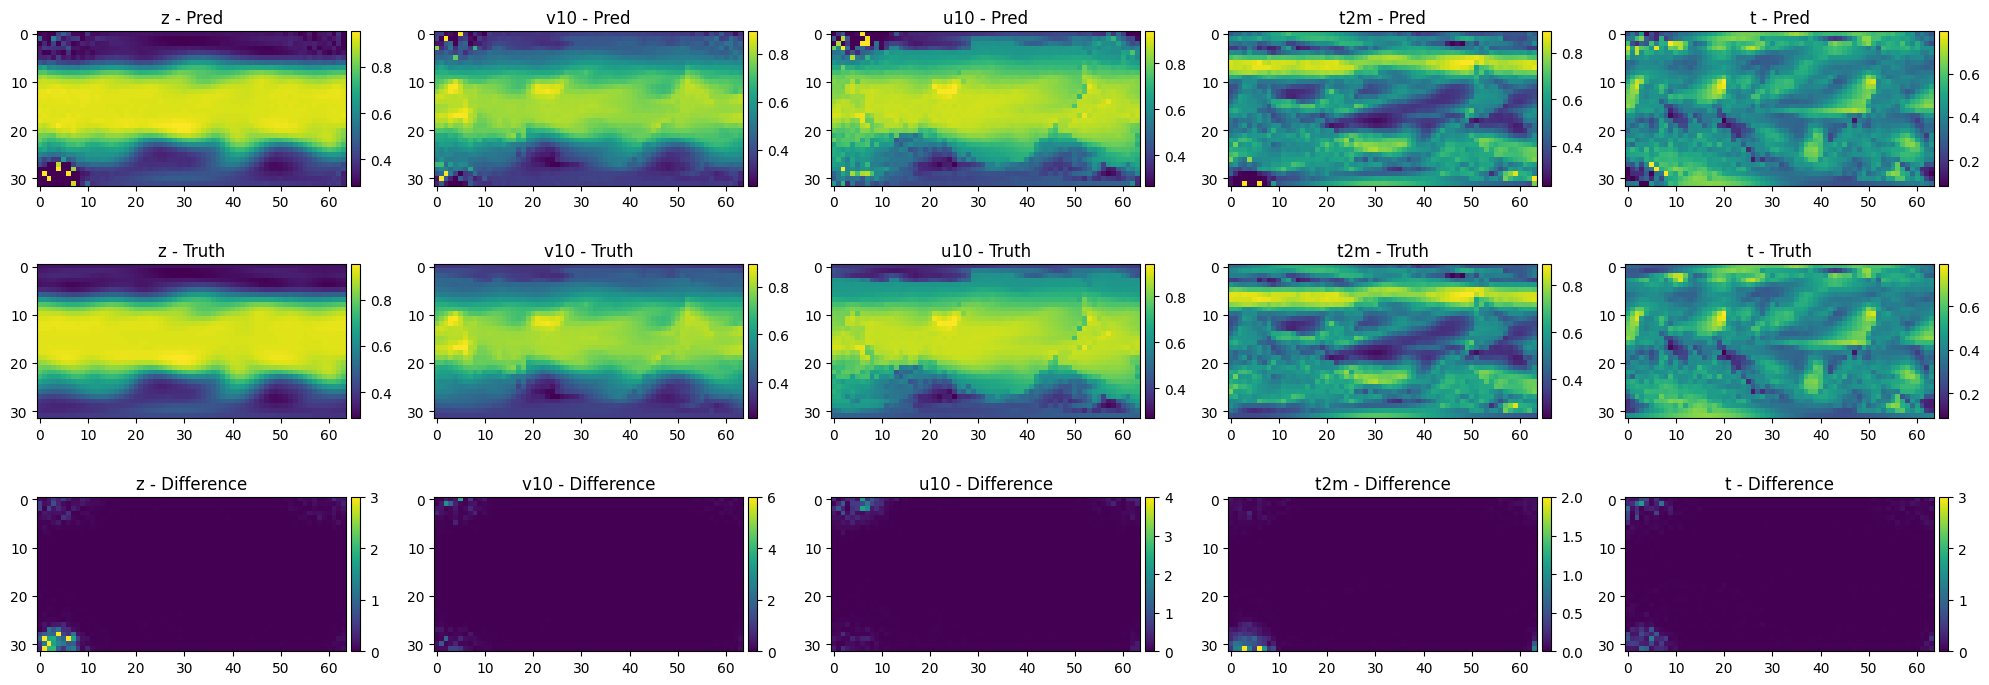

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

mean_pred_np = mean_pred[0][0].cpu().detach().numpy()
batch_np = batch[0][0].cpu().detach().numpy()

titles = ["z", "v10", "u10", "t2m", "t"]

# Create a figure with 5 columns and 3 rows of subplots (Prediction, Truth, and Difference)
fig, axes = plt.subplots(3, 5, figsize=(20, 12))

# Reduce spacing between images, with smaller hspace to shorten the vertical space between rows
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

# Plot each variable (z, v10, u10, t2m, t)
vmax_list = [3,6,4,2,3]
for i in range(5):
    vmin = batch_np[i].min()
    vmax = batch_np[i].max()
    
    # Top row (Prediction)
    ax1 = axes[0, i]
    im1 = ax1.imshow(mean_pred_np[i], cmap='viridis', vmin=vmin, vmax=vmax)
    ax1.set_title(f"{titles[i]} - Pred")
    
    # Add a small colorbar next to the top row images
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="3%", pad=0.05)  # Make the colorbar smaller
    fig.colorbar(im1, cax=cax1, orientation='vertical')

    # Middle row (Truth)
    ax2 = axes[1, i]
    im2 = ax2.imshow(batch_np[i], cmap='viridis', vmin=vmin, vmax=vmax)
    ax2.set_title(f"{titles[i]} - Truth")
    
    # Add a small colorbar next to the middle row images
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="3%", pad=0.05)  # Make the colorbar smaller
    fig.colorbar(im2, cax=cax2, orientation='vertical')

    # Bottom row (Difference)
    difference = (mean_pred_np[i] - batch_np[i])/batch_np[i]
    ax3 = axes[2, i]
    im3 = ax3.imshow(np.abs(difference), cmap='viridis', vmin=0, vmax=vmax_list[i])#
    ax3.set_title(f"{titles[i]} - Difference")

    # Add a small colorbar next to the bottom row images
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="3%", pad=0.05)  # Make the colorbar smaller
    fig.colorbar(im3, cax=cax3, orientation='vertical')

plt.tight_layout()
plt.show()
